In [1]:
%load_ext autoreload
%autoreload 2
import sklearn
import matplotlib
import matplotlib.font_manager as font_manager
import ncempy.io as nio
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import savgol_filter
import math
from sklearn.model_selection import train_test_split
from Analysis_objects_and_functions import *
from sklearn.metrics import r2_score
import glob
from mp_api.client import MPRester
from sklearn import tree
import pydotplus
import pickle
from platform import python_version
import ncempy.io as nio

No module named 'phonopy'
No module named 'phonopy'


In [2]:
print('python version ' + python_version())
print('pandas version ' + pd.__version__)
print('numpy version ' + np.__version__)
print('sklearn version ' + sklearn.__version__)
print('matplotlib version ' + matplotlib.__version__)
print('joblib version ' + joblib.__version__)

python version 3.10.12
pandas version 1.5.3
numpy version 1.24.3
sklearn version 1.0.2
matplotlib version 3.7.1
joblib version 1.1.0


In [3]:
import mp_api
from mp_api.client import MPRester

<font size="6"> Load Data and Define XAS/EELS Analysis Object

In [4]:
test_rf_obj = eels_rf_setup('Dataset_generation/Cu_reproducable_alignment_df_extracted_110222.joblib') 

# initialize analysis object and add dataset path to it 
test_rf_obj.load_spectra_df() # load dataframe 
test_rf_obj.spectra_df['BV Used For Alignment'] = test_rf_obj.spectra_df['NEW BV Used For Alignment'] 
test_rf_obj.spectra_df['mpid_string'] = test_rf_obj.spectra_df['mp_id'] 
test_rf_obj.spectra_df.drop('Structure', axis = 1, inplace = True)

test_rf_obj.augment_df_with_mixtures(len_mixtures = 100, len_combinations=20, gen_type ='random',
                                    include_mixtures_all = True) # run augmentation function that adds mixture spectra to the dataframe 

test_rf_obj.spectra_df['is_stable'] = np.zeros(len(test_rf_obj.spectra_df)) # this is no longer being stored as a part of the 
# model training and analysis
test_rf_obj.spectra_df['is_theoretical'] = np.zeros(len(test_rf_obj.spectra_df)) 

test_rf_obj.spectra_df.drop('level_0', axis = 1, inplace = True)
test_rf_obj.spectra_df.drop('index', axis = 1, inplace = True)

mp_id_all_string = []
for i in range(0, len(test_rf_obj.spectra_df)):
    mp_str = test_rf_obj.spectra_df.iloc[i].mpid_string
    if type(mp_str) == list:
        mp_str_list = []
        for mp in mp_str:
            try:
                mp_str_list.append(mp.string)
            except:
                mp_str_list.append(mp)
    else:
        mp_str_list = mp_str

    mp_str_list = str(mp_str_list)
    mp_id_all_string.append(mp_str_list)
test_rf_obj.spectra_df['full_mp_id_string'] = mp_id_all_string

In [5]:
# uncomment to visualize dataframe 
# print(test_rf_obj.spectra_df)

# percent of the test set that is an integer before mixture dataset is generated 
print(sum(np.asarray(test_rf_obj.spectra_df.iloc[0:3426]['BV Used For Alignment'].value_counts())[0:3])/3426)


0.9319906596614127


<font size="6"> Train Random Foreset Model and Visualize Results - All 3 Components of Figure 2

In [6]:
# train random forest model with the cumulative spectrum, 500 trees, no max depth and all features available  
test_rf_obj.random_forest_train_bond_valance(bv_column='BV Used For Alignment',
                           spectra_to_predict = 'Cumulative_Spectra_TEAM_1_aligned_925_970',
                        energy_col = 'new Scaled Energies use', split_by_id_mixed_valent = True, 
                                             max_features = 'auto')
# 0.8492826644187004

len training data = 7057
Using column: Cumulative_Spectra_TEAM_1_aligned_925_970 to predict: BV Used For Alignment
model accuracy (R^2) on simulated test data 0.8492826644187004


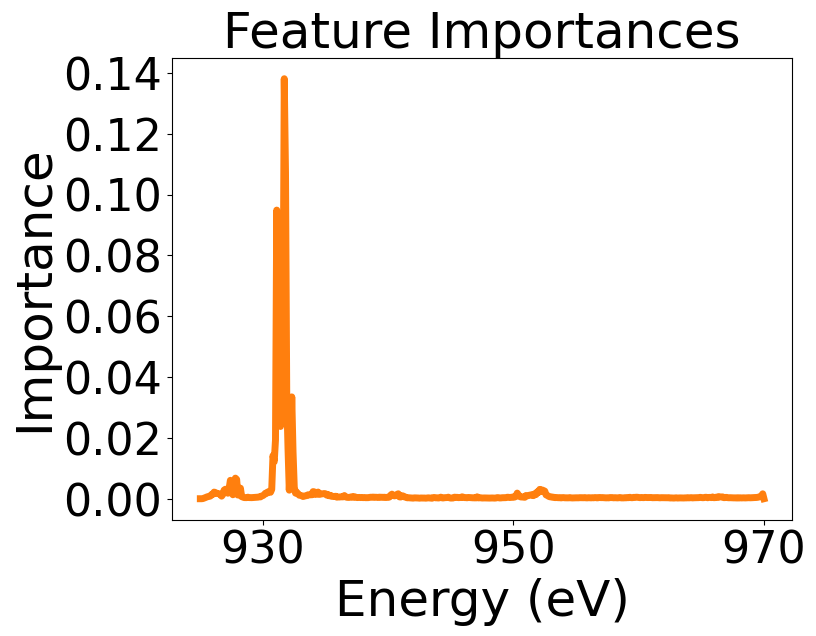

In [7]:
test_rf_obj.show_feature_importances('Cu', savefigure=False)
# visualize feature importances for the RF model 

num spectra = 2378
model accuracy (R^2) on simulated test data using Mean trees 0.8492826644187004
model accuracy (R^2) on simulated test data using Mean trees 0.8492826644187004
239
239
[147 124 100  83  65  50  47  39  35  27  27  27  26  26  25  23  23  22
  22  21  21  20  20  20  20  19  19  18  17  17  16  16  16  16  15  15
  15  15  14  14  14  14  14  14  14  13  13  13  13  13  13  13  12  12
  12  12  12  12  12  12  12  12  12  12  11  11  11  11  11  11  11  11
  10  10  10  10  10  10  10  10   9   9   9   9   9   9   9   9   8   8
   8   8   8   8   8   8   8   8   8   7   7   7   7   7   7   7   7   7
   7   7   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6   5
   5   5   5   5   5   5   5   5   5   5   5   5   4   4   4   4   4   4
   4   4   4   4   4   4   4   4   4   3   3   3   3   3   3   3   3   3
   3   3   3   3   3   3   3   3   3   3   3   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   1   1  

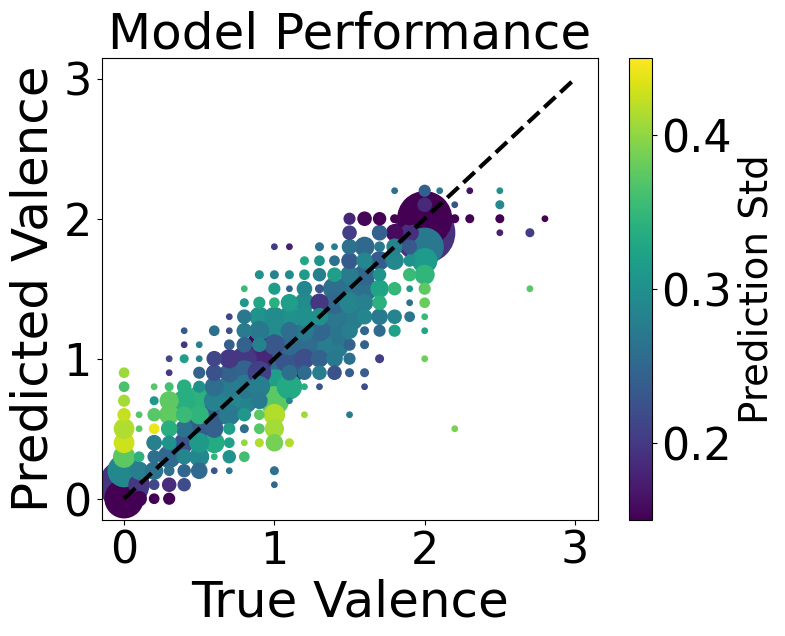

In [8]:
test_rf_obj.show_r2(savefigure=False)
# Show R2 plot for simulated data reserved from training. The top plot shows data colored by the number of points at 
# that position, while the bottom plot is colored by prediction standard deviation

RMSE 0.24153560211554492


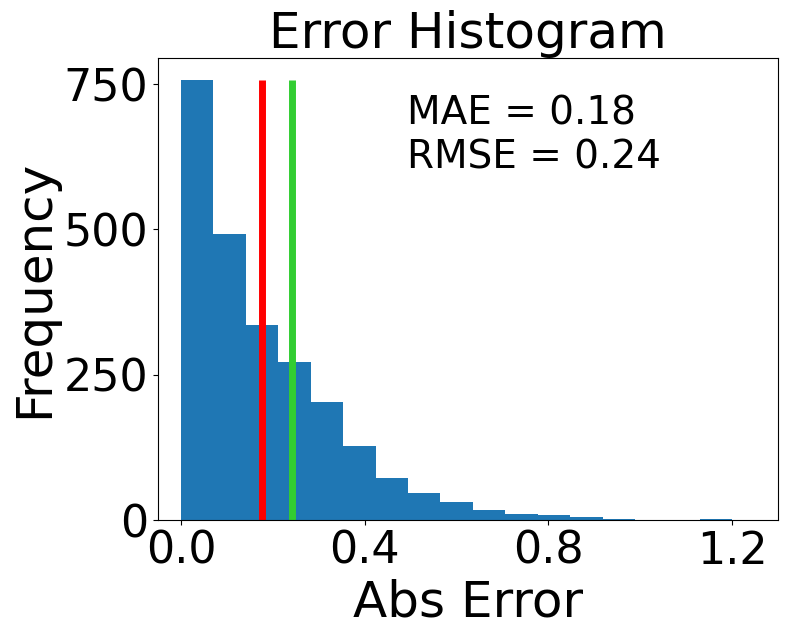

In [9]:
test_rf_obj.show_errors_histogram(nbins=25, savefigure=False)
# show error histogram for simulated data reserved from training. The solid green line is the location of the RMSE 
# 0.24153560211554492

<font size="6"> Visualize Dataset Distribution and The creation of Mixture Samples. Figure 1 II and III, and Figure S4

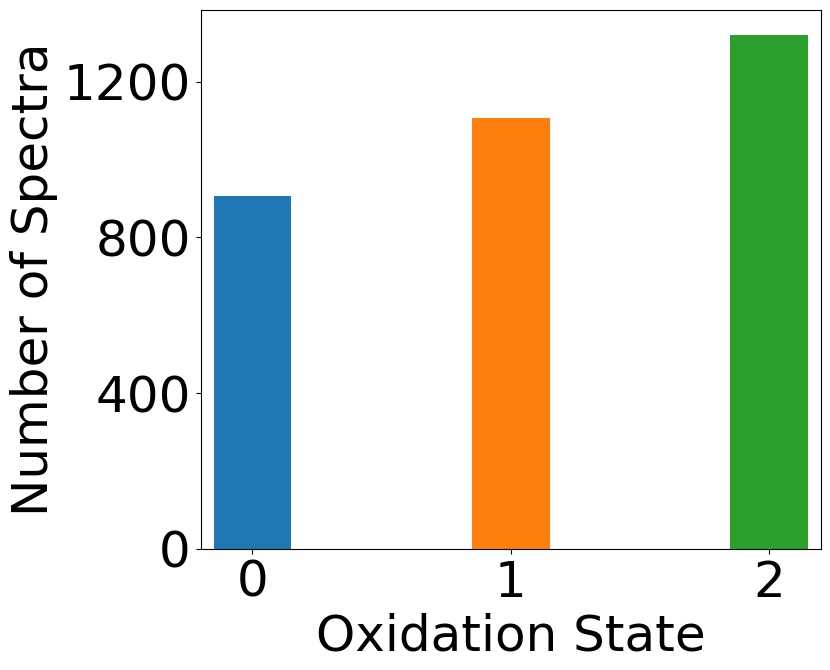

In [10]:
# show the number of integer valence spectra in the dataset before mixture generation 
test_rf_obj.visualize_mixture_addition(include_mixtures=False, savefigure=False)

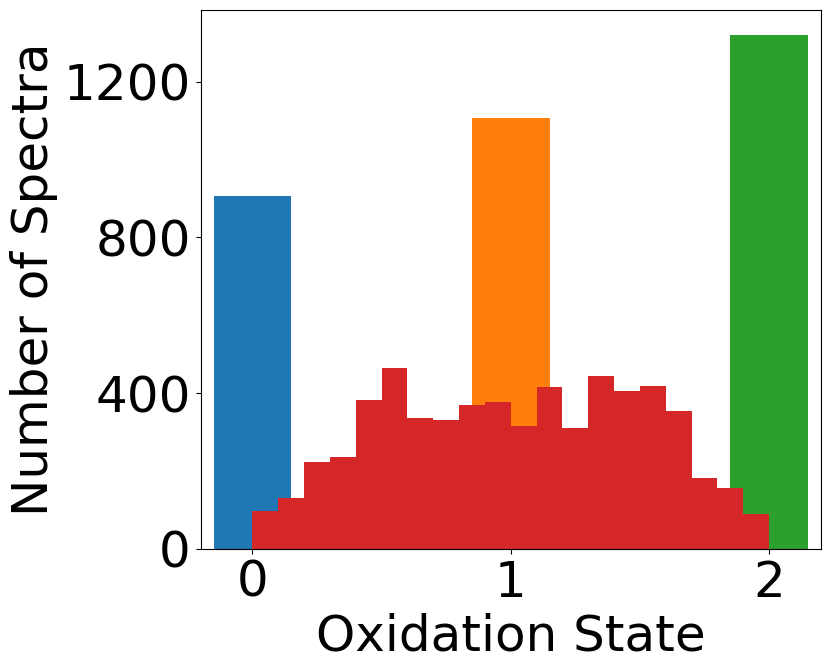

In [11]:
# show the spread of oxidation states post mixture dataset generation 
test_rf_obj.visualize_mixture_addition(include_mixtures=True, savefigure=False, right_y_ticks = False, bins=np.linspace(0.0, 2.0, 21))

In [15]:
# show the spread of oxidation states post mixture dataset generation 
# test_rf_obj.spectra_df.drop('Structure', inplace = True, axis = 1)

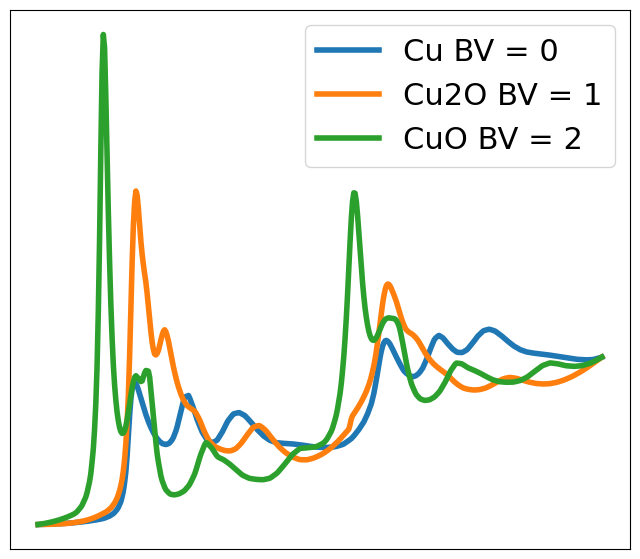

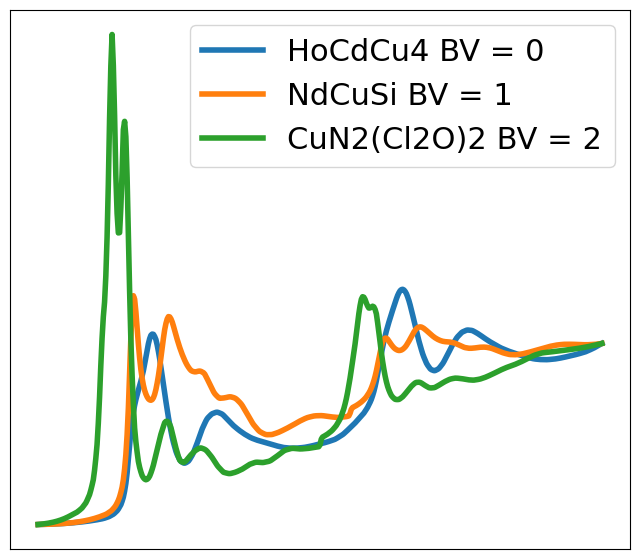

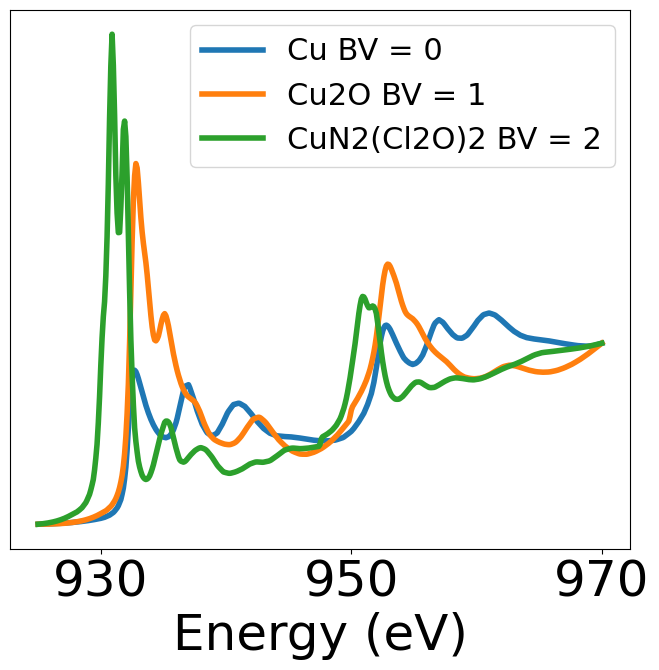

In [13]:
# visualize specific integer oxidation state spectra 
test_rf_obj.visualize_mixture_components('mp-30', 'mp-361', 'mp-704645', include_title=False, include_ticks = False, 
                                         savefigure=False)
test_rf_obj.visualize_mixture_components('mp-12007', 'mp-8120', 'mp-1188453', include_title=False, savefigure=False, include_ticks = False)
test_rf_obj.visualize_mixture_components('mp-30', 'mp-361', 'mp-1188453', include_title=False, include_ticks = True, 
                                         savefigure=False)

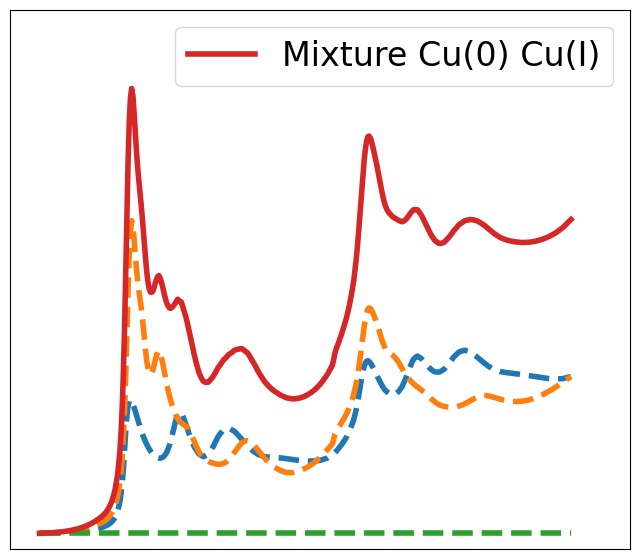

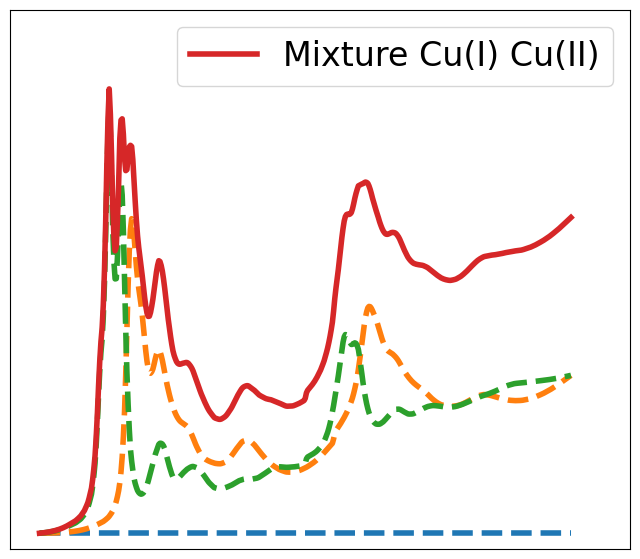

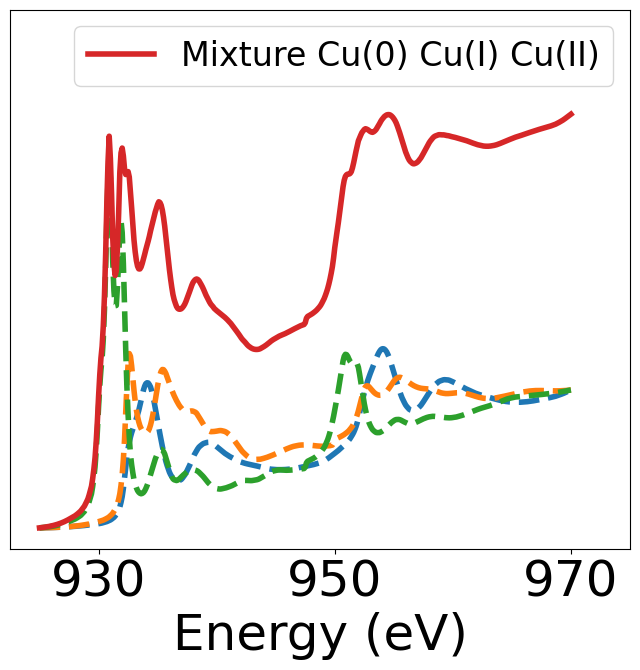

In [14]:
# visualize how integer valent spectra combine to make mixture datasets in the 3 different types of mixtures present in this 
# dataset: mixtures of Cu(0) and Cu(I), mixtures of Cu(I) and Cu(II) and mixtures of all three integer oxidation states 
test_rf_obj.visualize_mixtures('mp-30', 'mp-361', 'mp-1188453', 0.5, 0.5, 0.0, include_title = False, savefigure = False, 
                               include_ticks = False)
test_rf_obj.visualize_mixtures('mp-30', 'mp-361', 'mp-1188453', 0.0, 0.5, 0.5, include_title = False, savefigure = False)
test_rf_obj.visualize_mixtures('mp-12007', 'mp-8120', 'mp-1188453', 0.33, 0.33, 0.33, include_ticks = True, include_title = False,
                  savefigure = False)

<font size="6"> Validation on Experimental Samples. Figure 1 IV and Figure 3

Predicting From Cu_deconvolved_spectra\Cu Metal Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


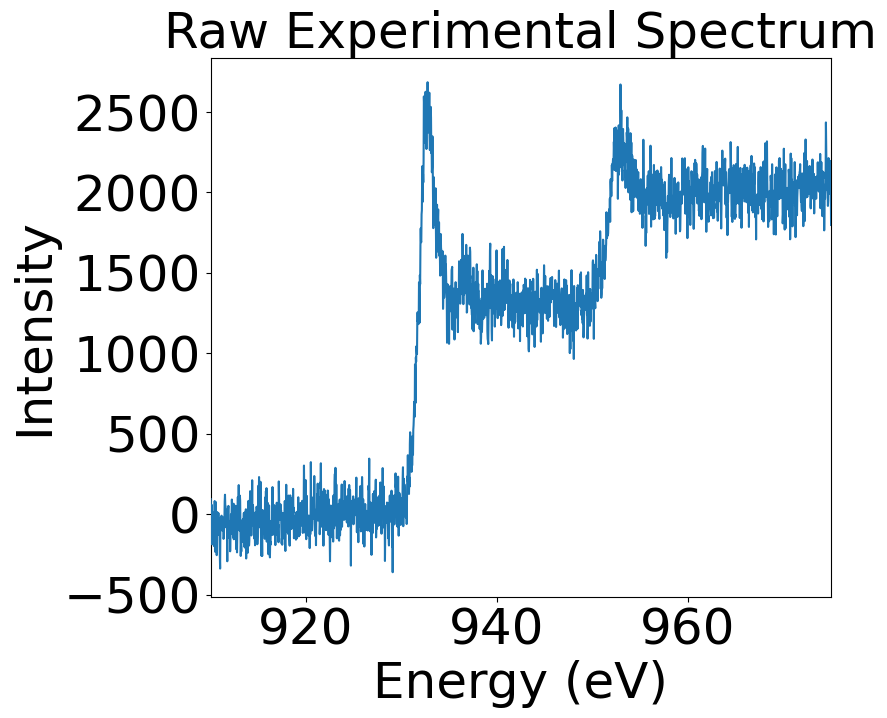

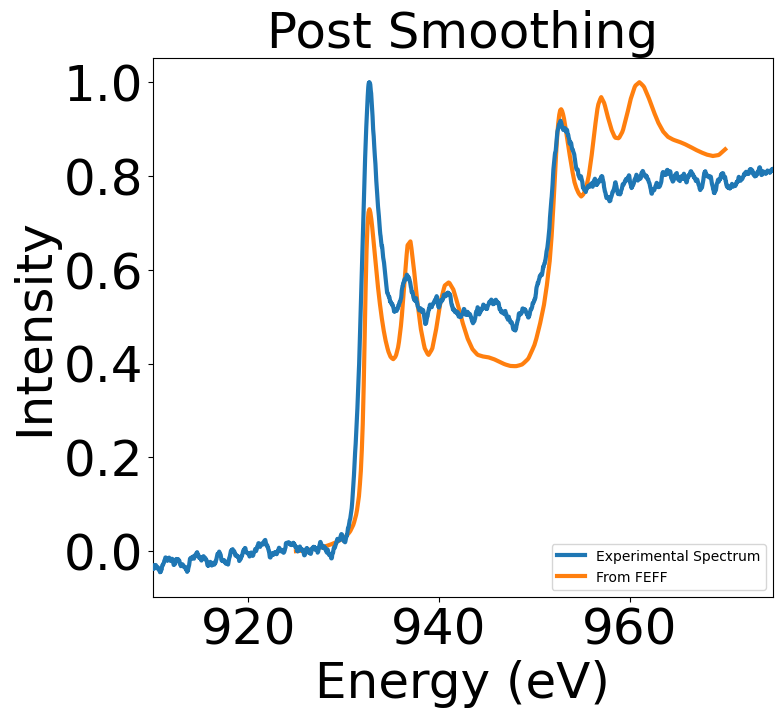

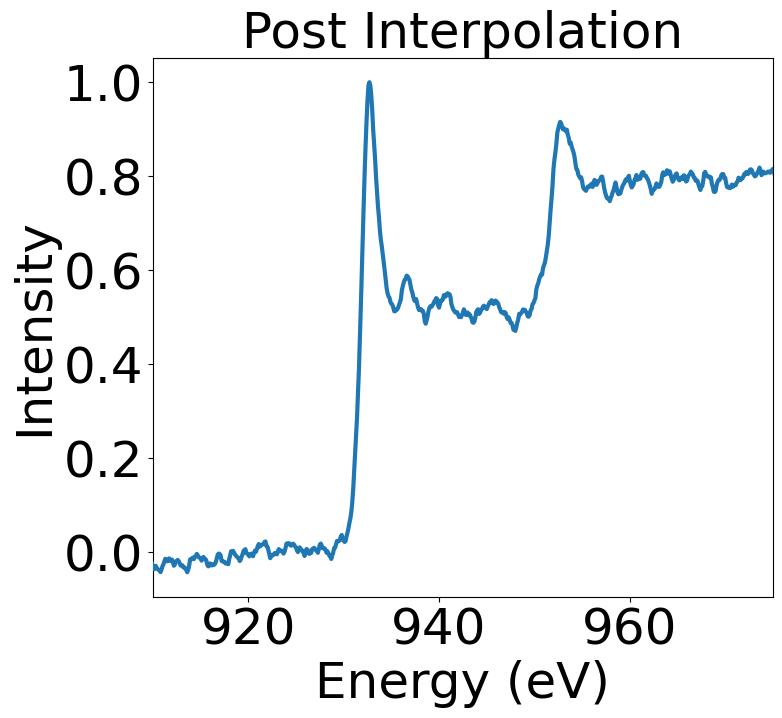

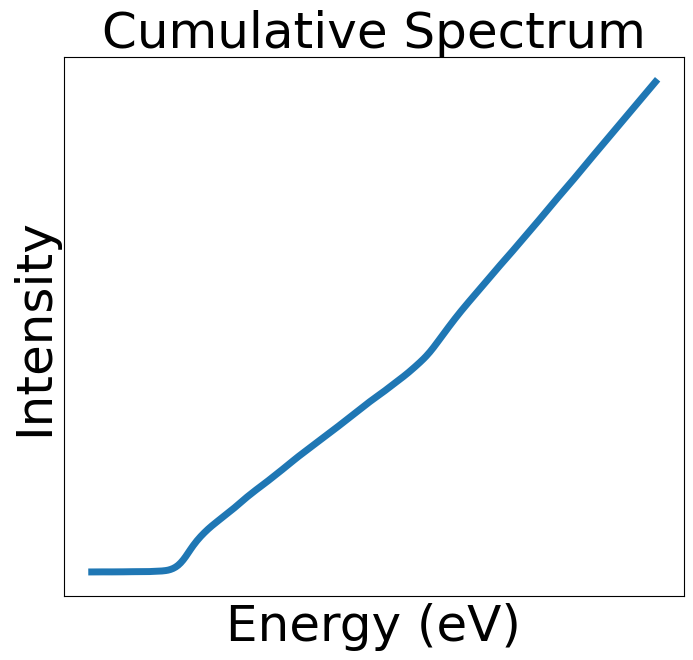

Prediction Median = 0.05
prediction = 0.3
prediction std = 0.38
 


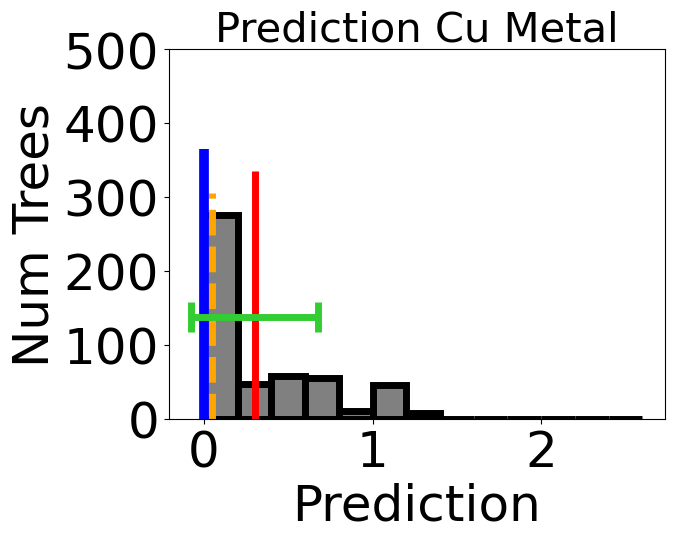

Predicting From Cu_deconvolved_spectra\Cu2O Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


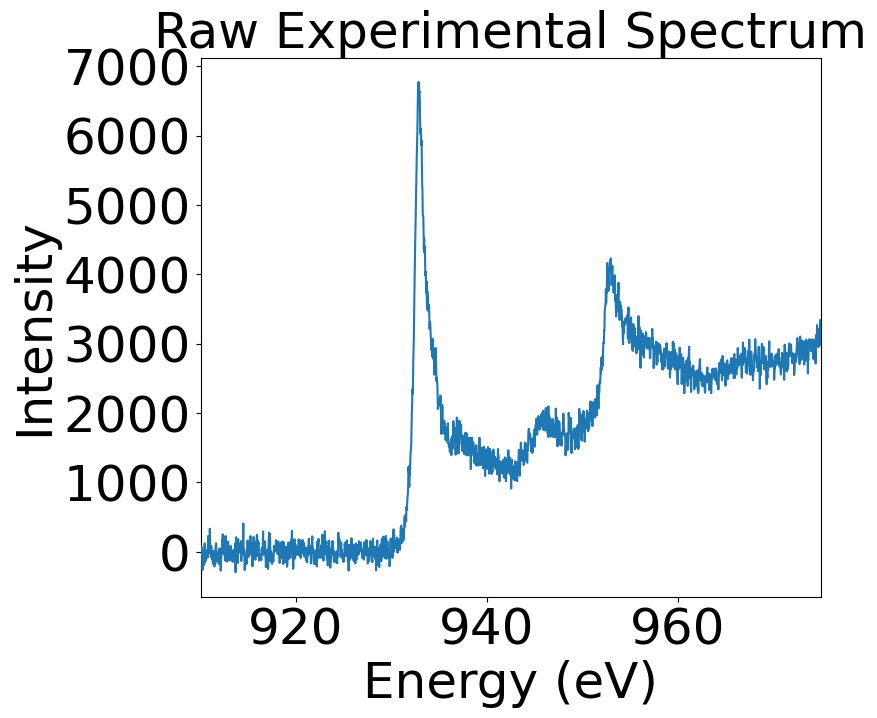

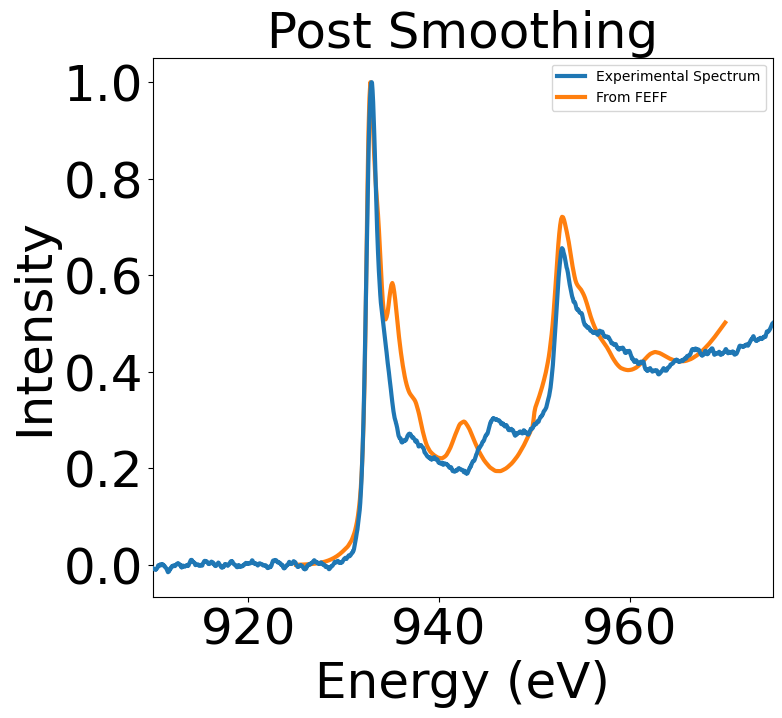

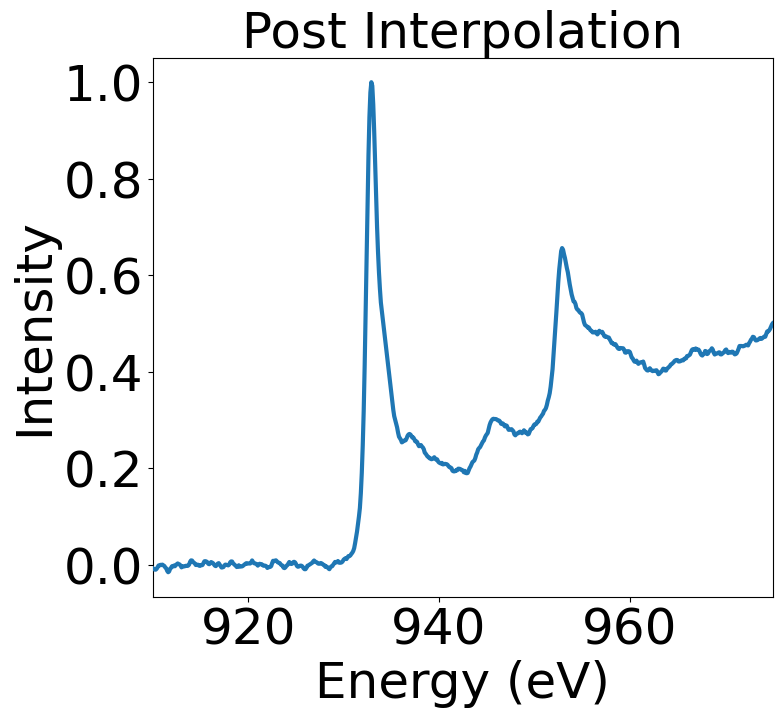

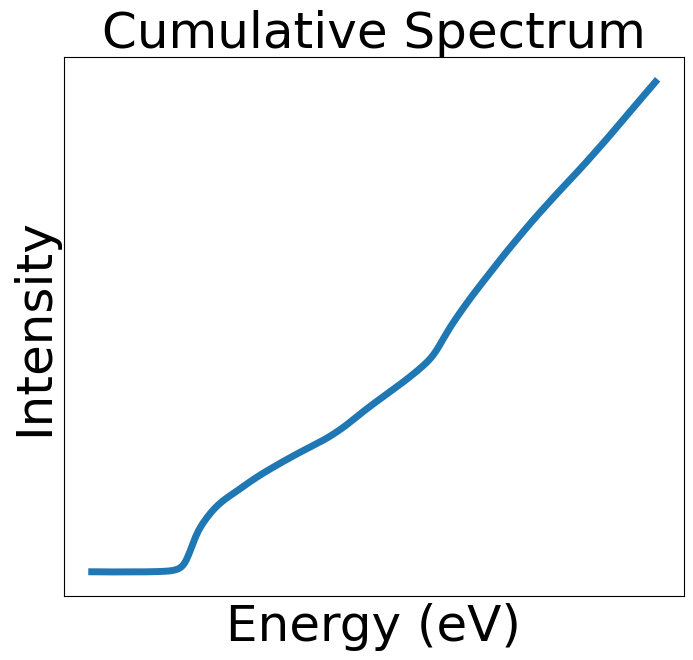

Prediction Median = 1.0
prediction = 1.03
prediction std = 0.18
 


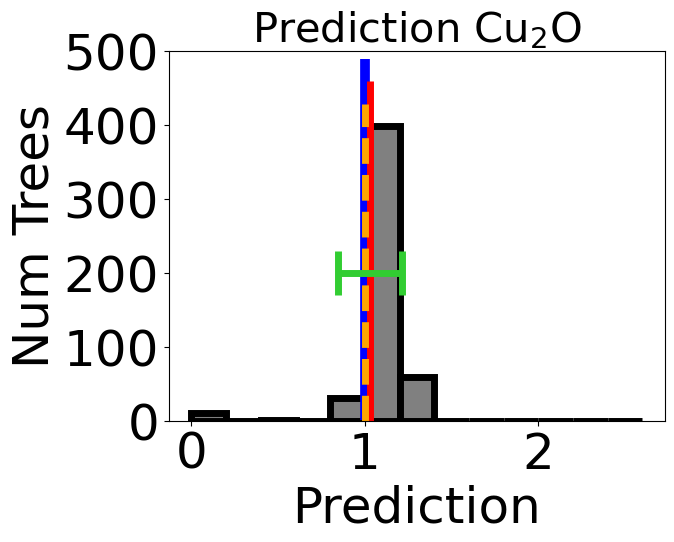

Predicting From Cu_deconvolved_spectra\CuO Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


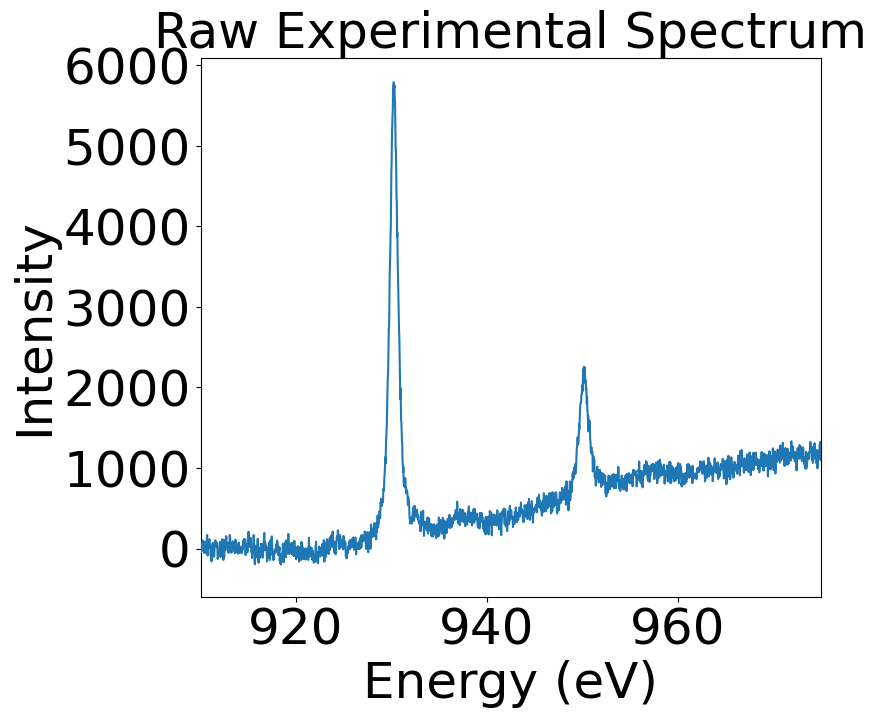

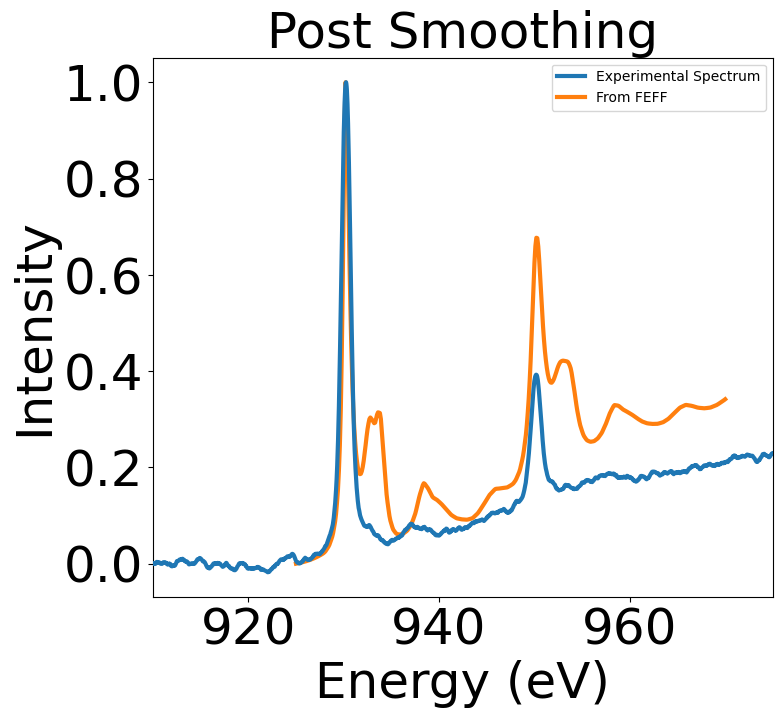

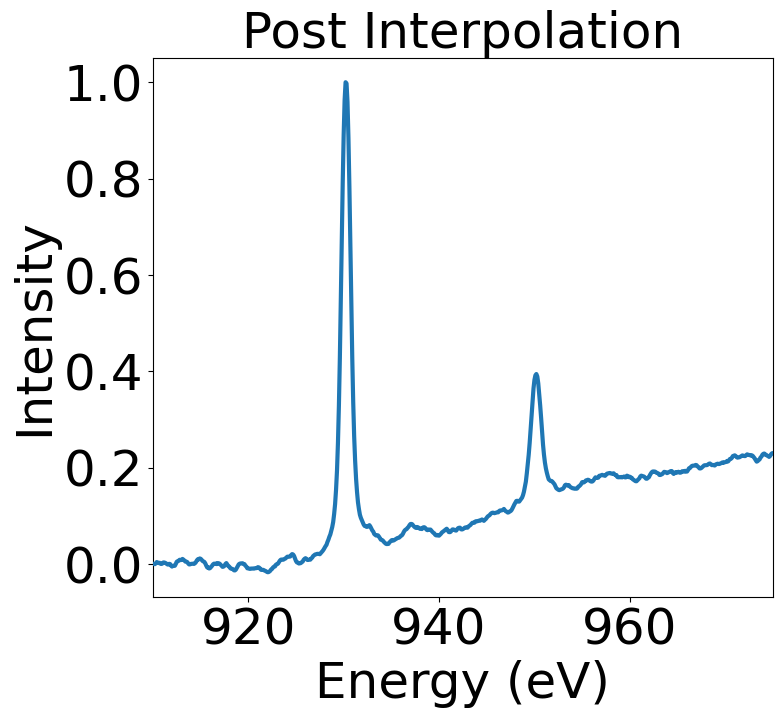

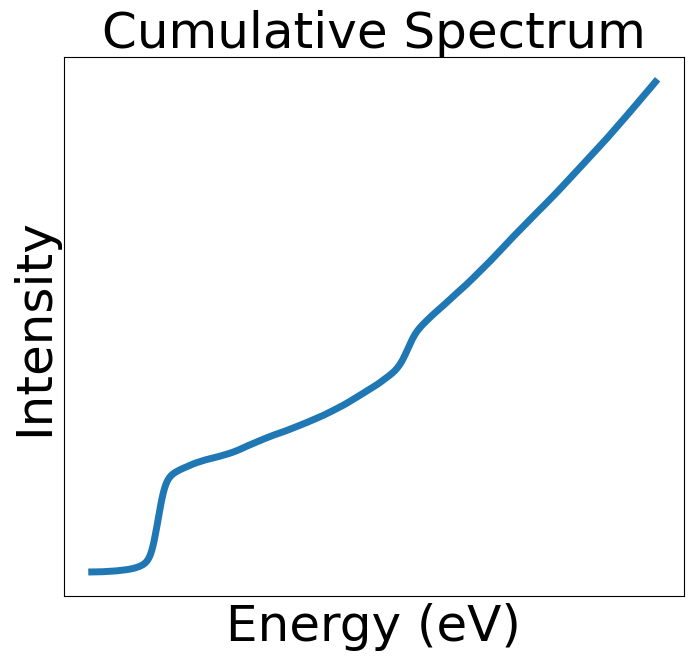

Prediction Median = 2.0
prediction = 2.1
prediction std = 0.24
 


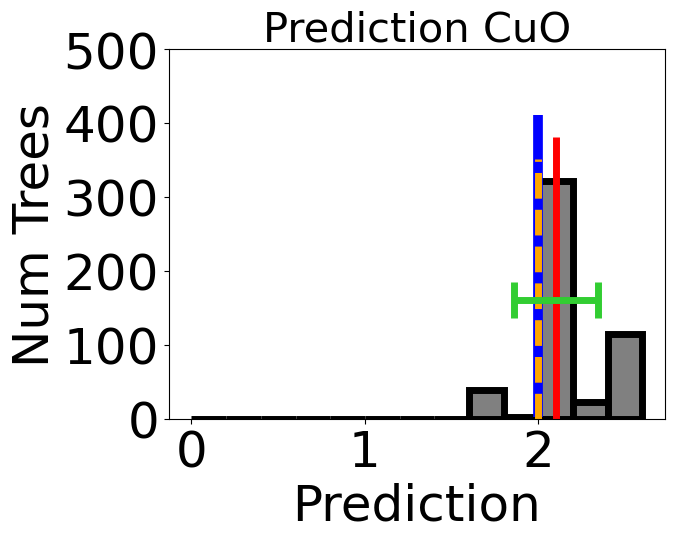

In [15]:
# predict the standards from the three experimental standards taken in this work
test_rf_obj.predict_experiment_folder('Cu_deconvolved_spectra/', spectra_type = 'TEAM I', 
                                      shifts = [0], theory_column = 'TEAM_1_aligned_925_970', smoothings = [[51,3]], 
                                      show_hist=True, show_inputted_spectrum=True, print_details = True, show_plots=True,
                                     savefigure=False, theory_indicies = [1644, 2246, 824])

Predicting From Cu_deconvolved_spectra\Cu Metal Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


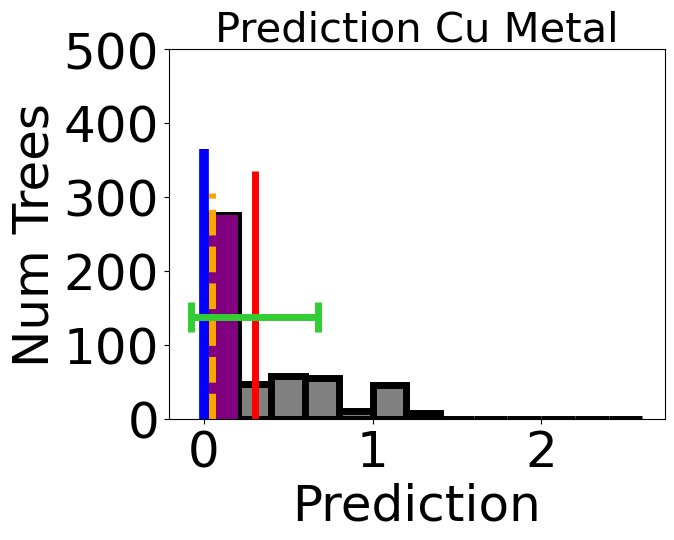

Prediction Mode = 0.1
Prediction Median = 0.05
Prediction = 0.3
Prediction Std = 0.38
 
Predicting From Cu_deconvolved_spectra\Cu2O Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


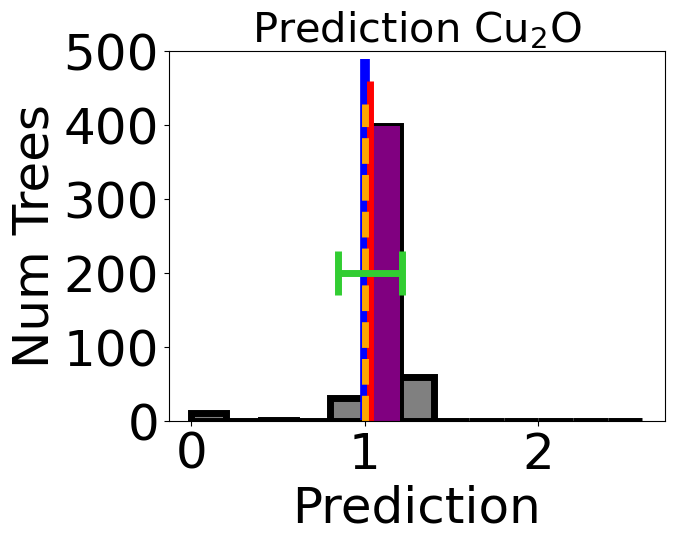

Prediction Mode = 1.1
Prediction Median = 1.0
Prediction = 1.03
Prediction Std = 0.18
 
Predicting From Cu_deconvolved_spectra\CuO Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


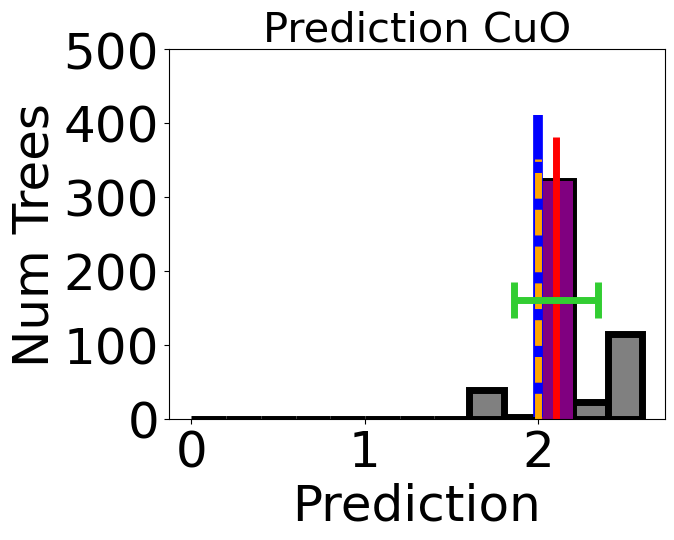

Prediction Mode = 2.1
Prediction Median = 2.0
Prediction = 2.1
Prediction Std = 0.24
 


In [59]:
# predict the standards from the three experimental standards taken in this work
test_rf_obj.predict_experiment_folder('Cu_deconvolved_spectra/', spectra_type = 'TEAM I', 
                                      shifts = [0], theory_column = 'TEAM_1_aligned_925_970', smoothings = [[51,3]], 
                                      show_hist=True, show_inputted_spectrum=False, print_details = True, show_plots=False,
                                     savefigure=False, theory_indicies = [1644, 2246, 824])

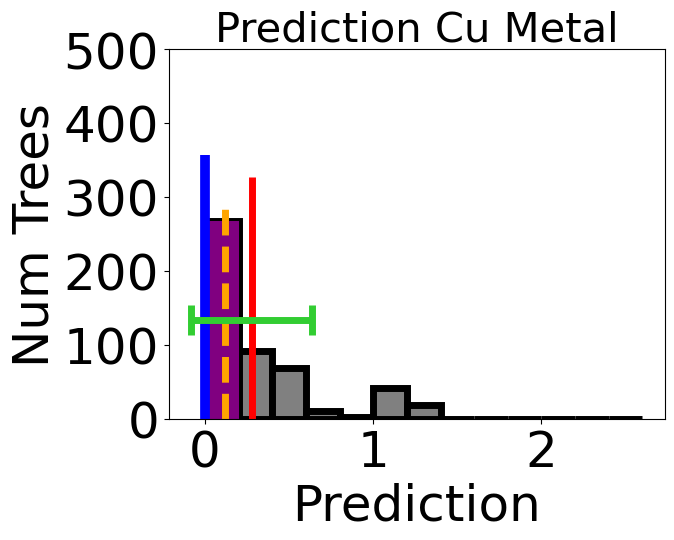

Prediction Mode = 0.1
Prediction Median = 0.12
Prediction = 0.28
Prediction Std = 0.36
 


In [66]:
test_rf_obj.predict_experiment_random_forest('C:/Users/smgls/Materials_database/xas paper/Cu Metal XAS.csv',
                                             1644, 'Cu Metal', exp_spectrum_type='csv',
                                            smoothing_parms=[15,3], points_to_average=10, cumulative_spectrum=True,
                                            spectrum_energy_shift=-1.0, theory_column='TEAM_1_aligned_925_970', 
                                            energies_range=[925,970], show_hist=True, show_plots=False, show_inputted_spectrum = False,
                                            savefigure=False, check_alignment = False)

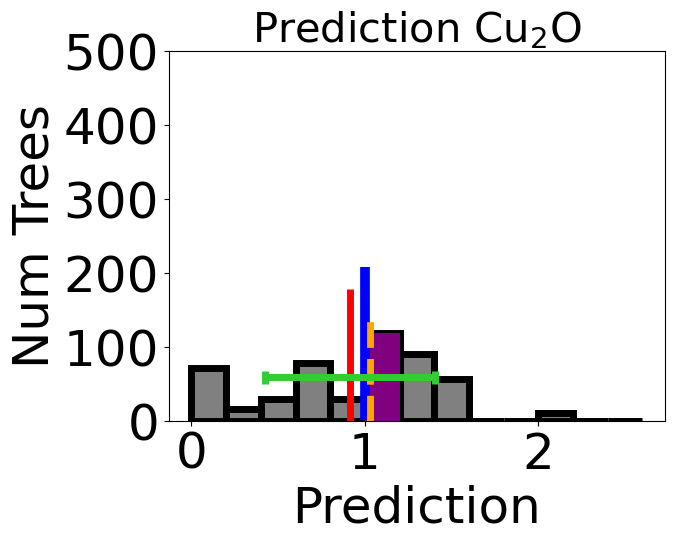

Prediction Mode = 1.1
Prediction Median = 1.03
Prediction = 0.91
Prediction Std = 0.49
 


In [69]:
test_rf_obj.predict_experiment_random_forest('C:/Users/smgls/Materials_database/xas paper/Cu2O XAS.csv',
                                             2246, 'Cu2O', exp_spectrum_type='csv',
                                            smoothing_parms=[15,3], points_to_average=10, cumulative_spectrum=True,
                                            spectrum_energy_shift=-1.2, theory_column='TEAM_1_aligned_925_970', 
                                            energies_range=[925,970], show_hist=True, show_plots=False, show_inputted_spectrum = False,
                                            savefigure=False, check_alignment = False)

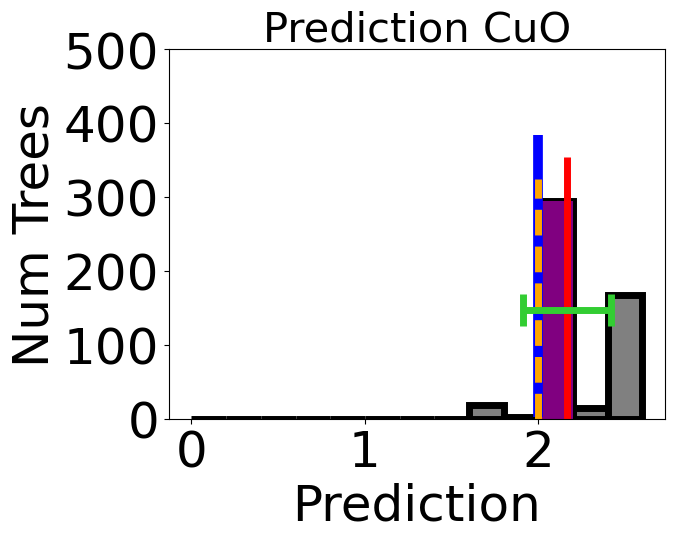

Prediction Mode = 2.1
Prediction Median = 2.0
Prediction = 2.17
Prediction Std = 0.26
 


In [70]:
test_rf_obj.predict_experiment_random_forest('C:/Users/smgls/Materials_database/xas paper/CuO XAS.csv',
                                             824, 'CuO', exp_spectrum_type='csv',
                                            smoothing_parms=[15,3], points_to_average=10, cumulative_spectrum=True,
                                            spectrum_energy_shift=-1.2, theory_column='TEAM_1_aligned_925_970', 
                                            energies_range=[925,970], show_hist=True, show_plots=False, show_inputted_spectrum = False,
                                            savefigure=False, check_alignment = False)

<font size="6"> Visualize Energy Axis Shift For Experimental Samples. Figure 4

In [17]:
shifts = np.linspace(-1.5,1.5,31)

In [18]:
# shift the experimental spectra energy axis and visualize how that impacts prediction 
test_rf_obj.predict_experiment_folder('Cu_deconvolved_spectra/', spectra_type = 'TEAM I', 
                                      shifts = shifts, theory_column = 'TEAM_1_aligned_925_970', smoothings = [[51,3]],
                                     print_details = False, theory_indicies = [1644, 2246, 824])

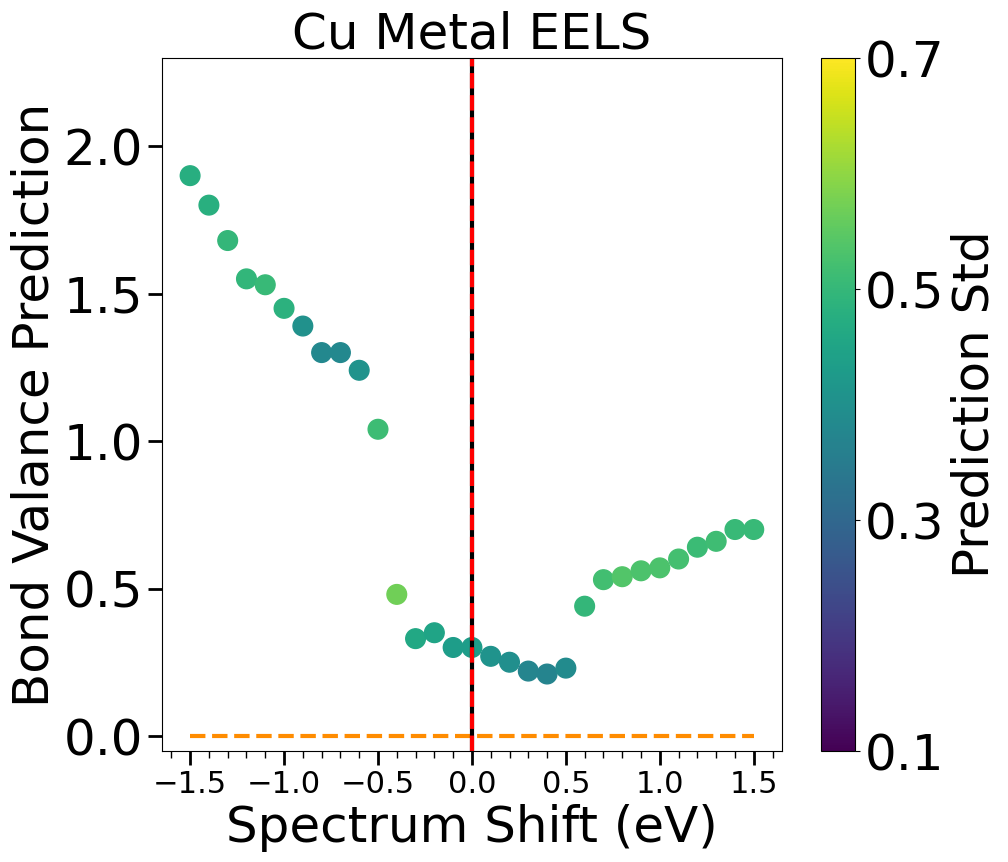

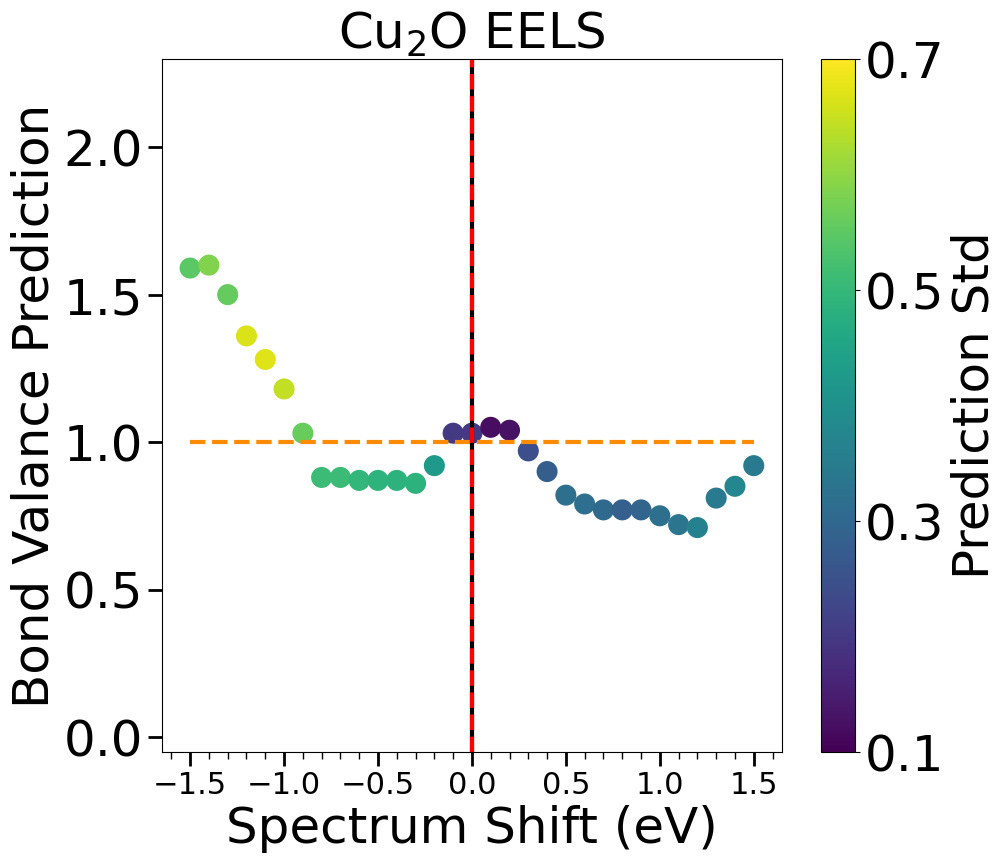

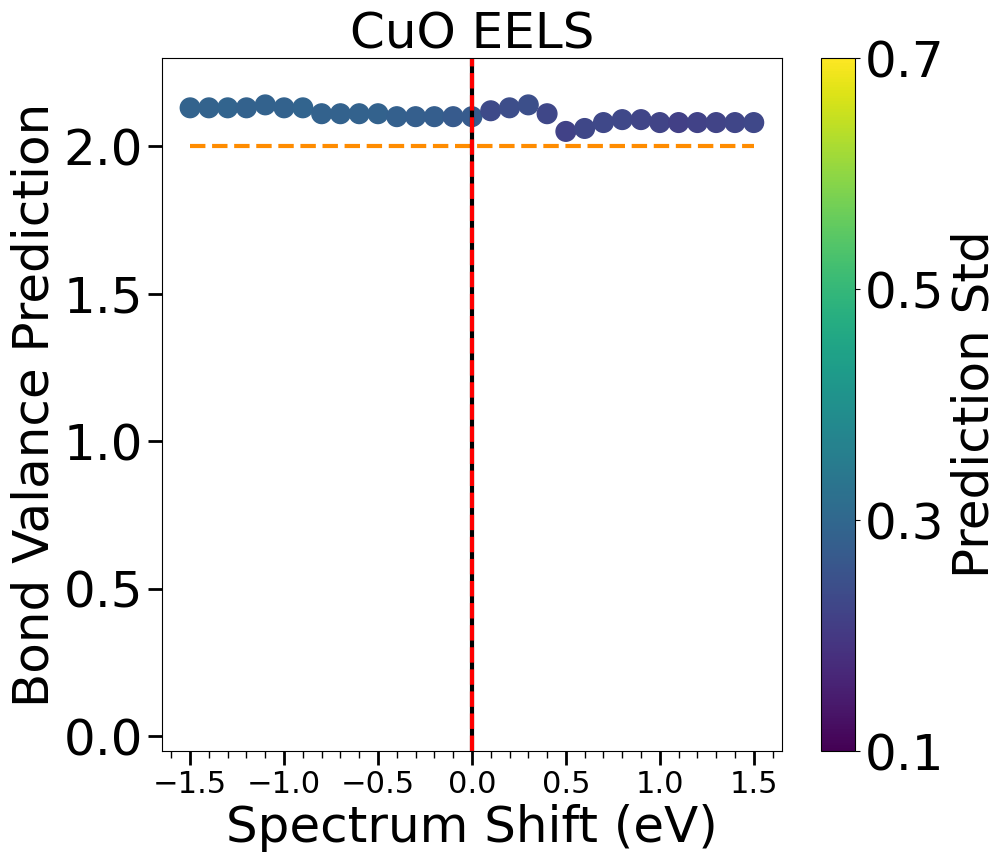

In [24]:
# must run the above cell before this visualization code will work
test_rf_obj.visualize_shift(material = 'All', show_stds = False, show_table = False, savefigure=False, spectrum_type = 'EELS',
                            show_shift_labels = True, shift_labels = [0.0, 0.0, 0.0], show_true_val=True, theory_index = [1644, 2246, 824])

In [25]:
# shift the literature spectra energy axis and visualize how that impacts prediction 
# smoothing window is 15 rather than 51 because the extracted literature spectra aren't on an even spacing and need to be 
# interpolated before they can be smoothed. Therefore they are interpolated to 0.1 eV spacing first and then smoothed, 
# so the smoothing window must be correspondingly adjusted to make sure the energy window size remains at 1.5 eV 
test_rf_obj.predict_experiment_folder('xas paper/', spectra_type = 'csv', 
                                      shifts = shifts, theory_column = 'TEAM_1_aligned_925_970', smoothings = [[15,3]],
                                     print_details = False, show_hist=False, show_plots=False, theory_indicies = [1644, 2246, 824])


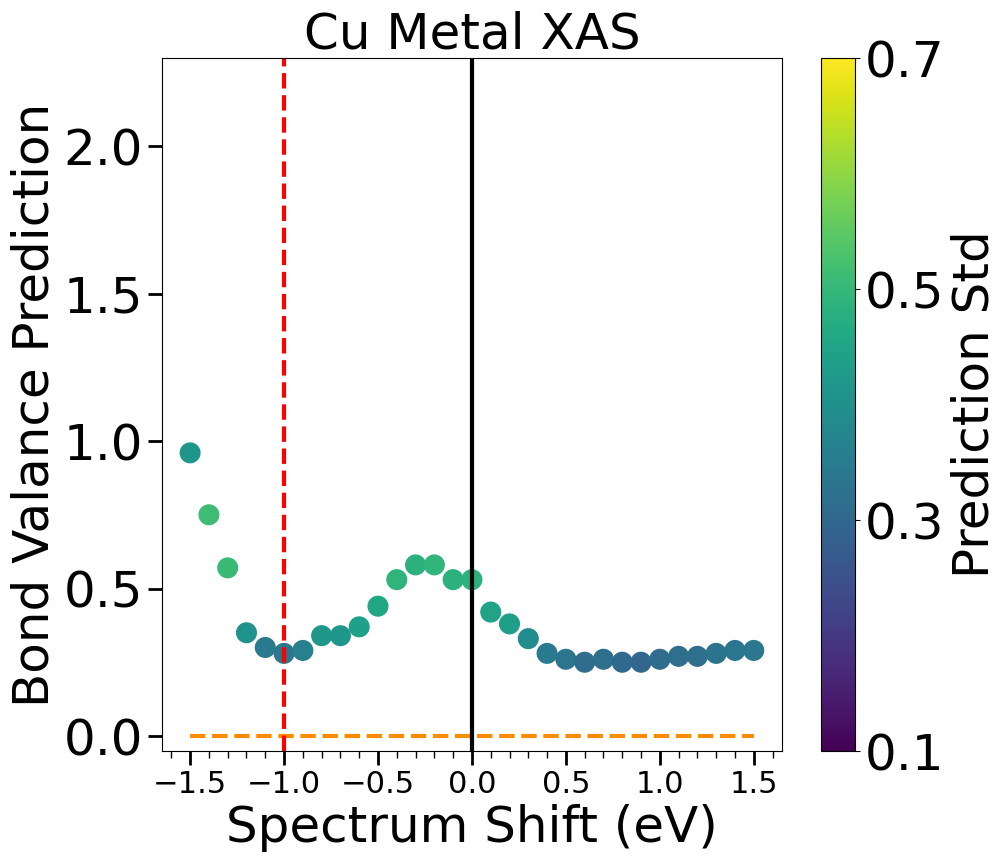

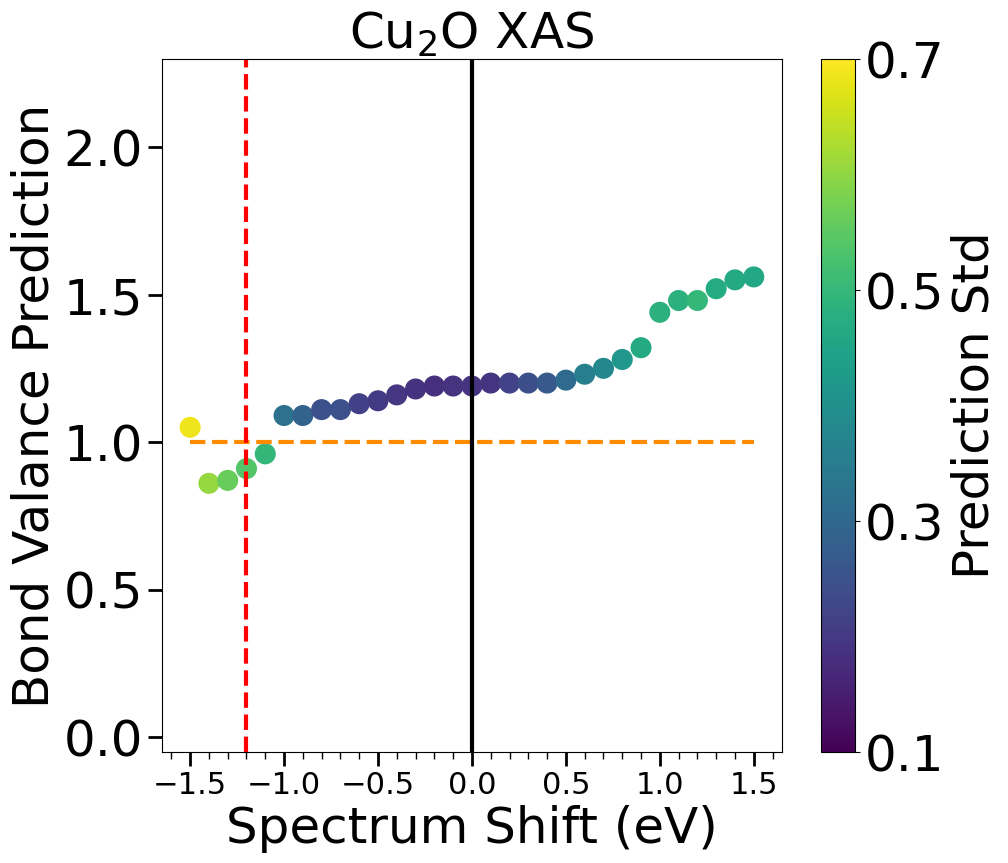

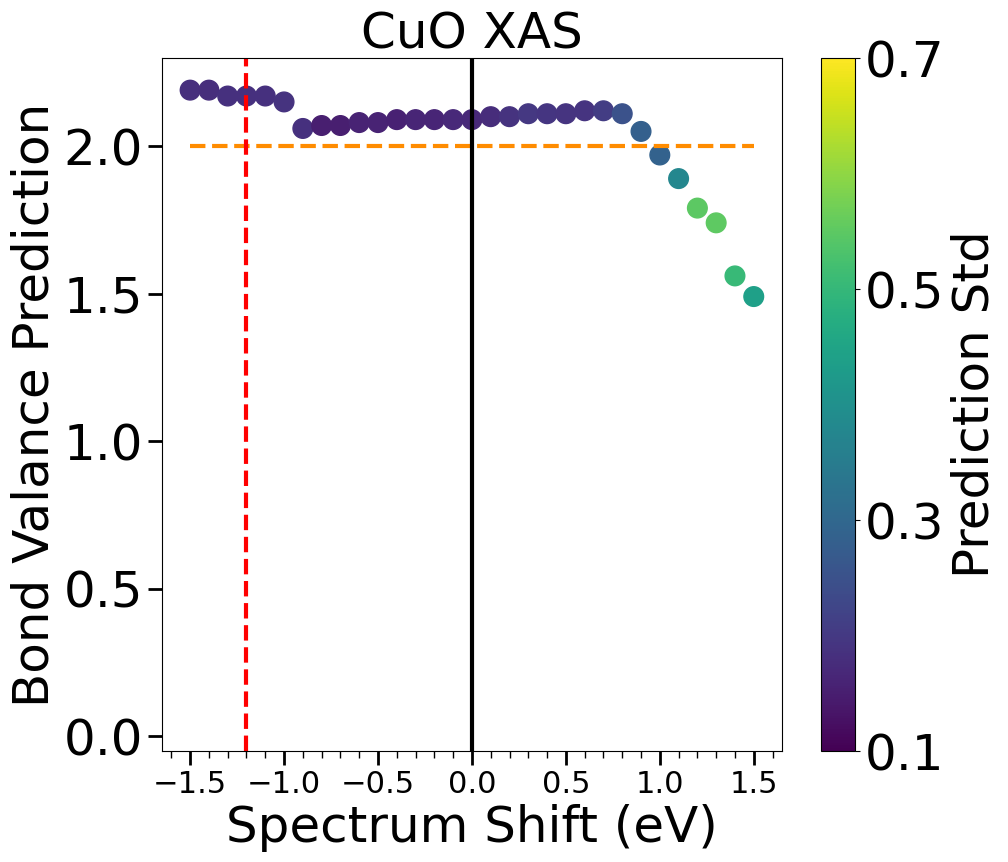

In [26]:
# must run the above cell before this visualization code will work
test_rf_obj.visualize_shift(material = 'All', show_stds = False, show_table = False, savefigure=False, show_shift_labels = True,
                                     shift_labels = [-1, -1.2, -1.2], spectrum_type = 'XAS',  show_true_val=True, theory_index = [1644, 2246, 824])

<font size="6"> Predict Experimental Mixtures. Figure 5

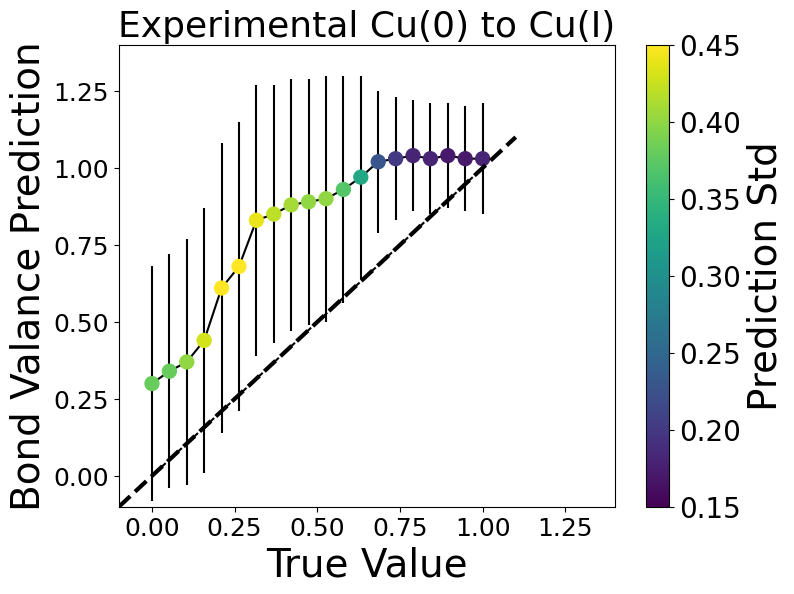

In [27]:
# predict experimental mixtures of Cu(0) and Cu(I) and Cu(I) and Cu(2)  
test_rf_obj.experimental_mixed_valent(catagory = '0-1', colorbar_range = [0.15, 0.45], savefigure = False, true_vals = [0.0, 1.00, 2.00],
                                     show_hists = False)

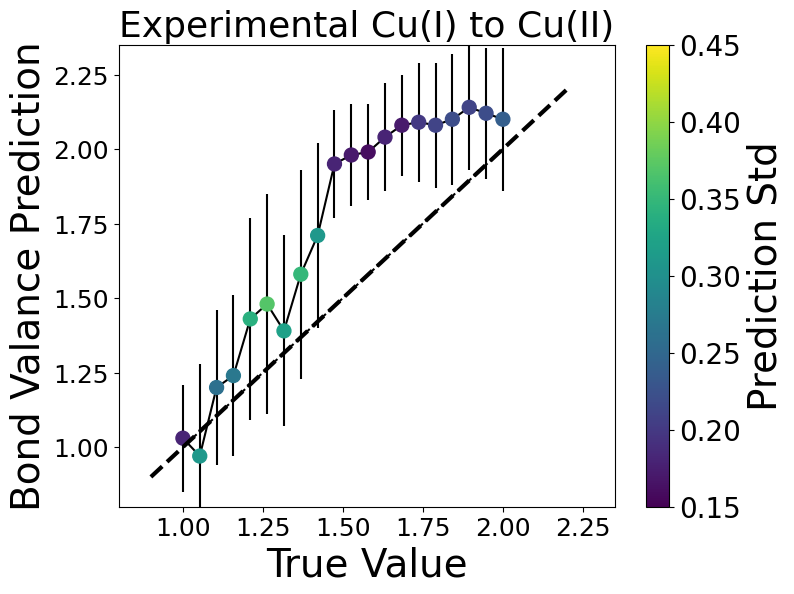

In [28]:
test_rf_obj.experimental_mixed_valent(catagory = '1-2', colorbar_range = [0.15, 0.45], savefigure = False, true_vals = [0.0, 1.00, 2.00],
                                     show_hists = False)

<font size="6"> Augment Test Set With Noise and Predict Noisy Spectra. Figure 6

In [29]:
# interpolate test set so spectra are on a 0.03 eV spacing, the same as our experimental standards 
test_rf_obj.add_interp_spec_to_ERROR_df([0.03], False,925)

0.03


0


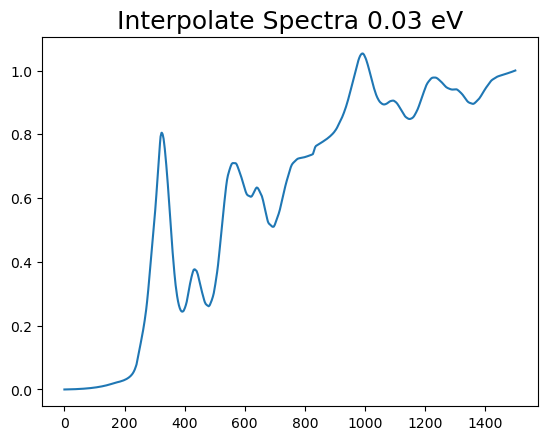

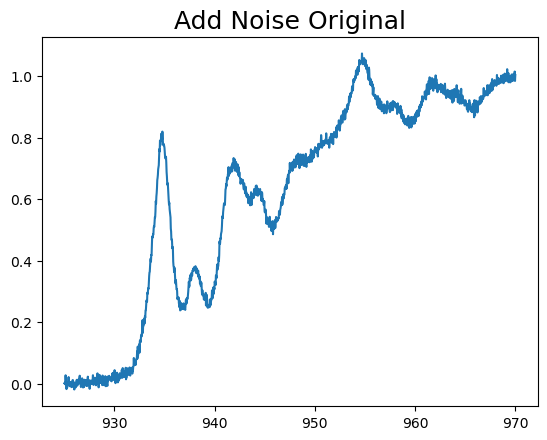

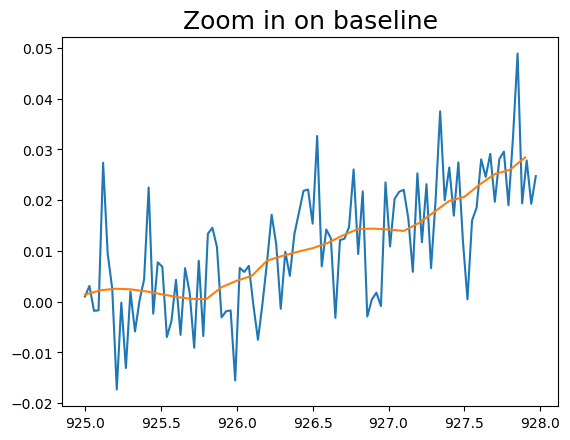

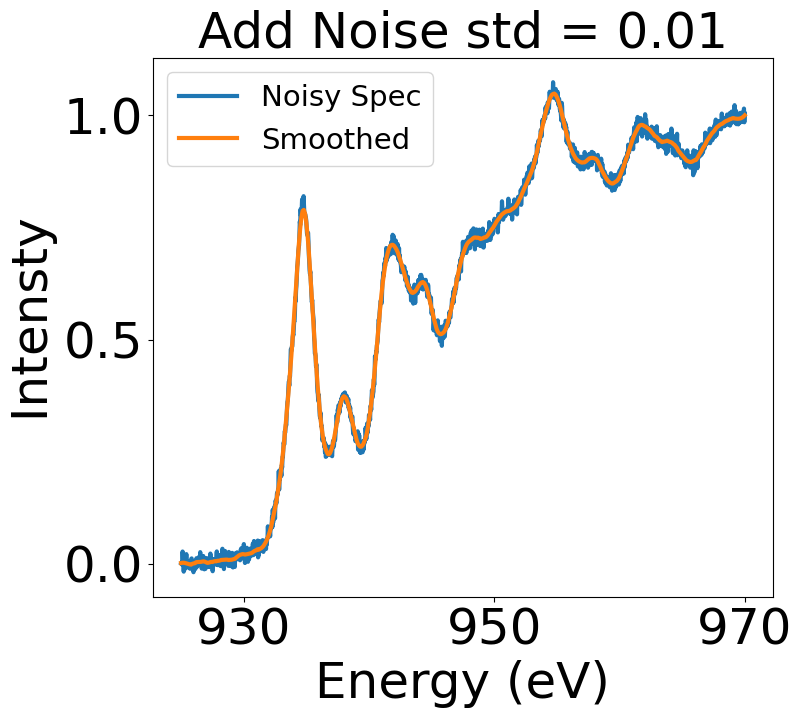

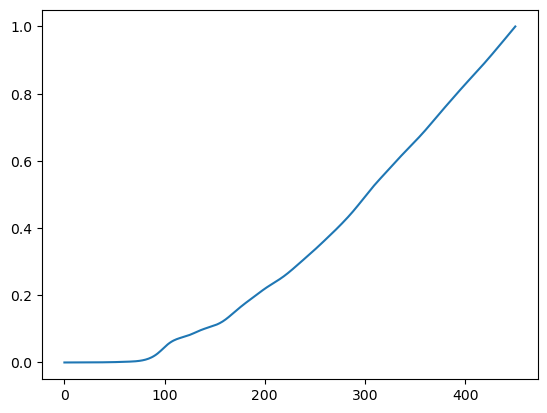

model accuracy (R^2) on simulated test data 0.8664514681756252
0.228776422721066


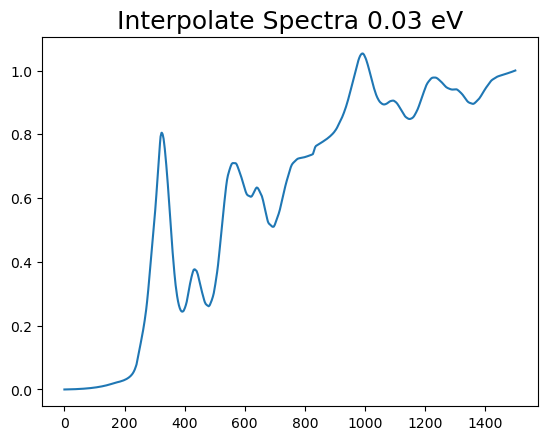

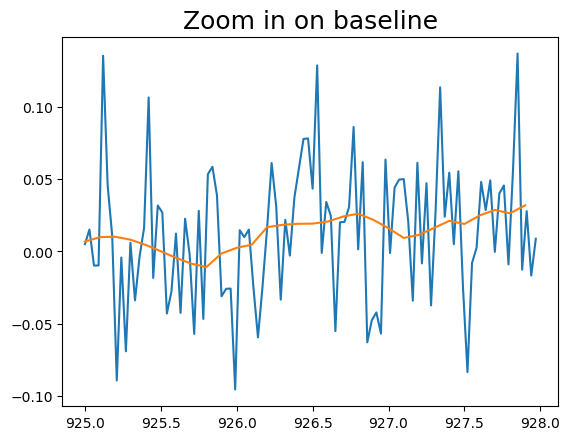

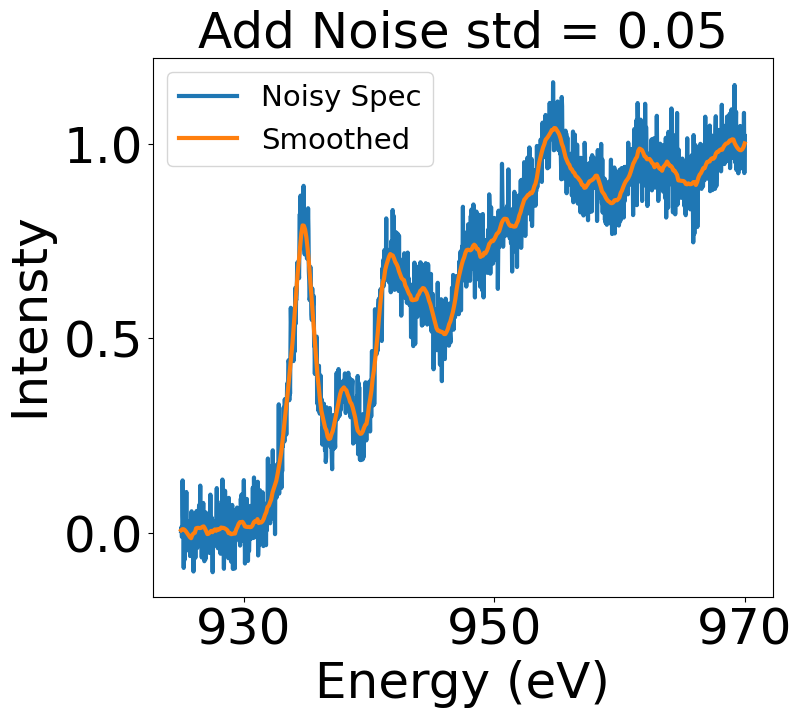

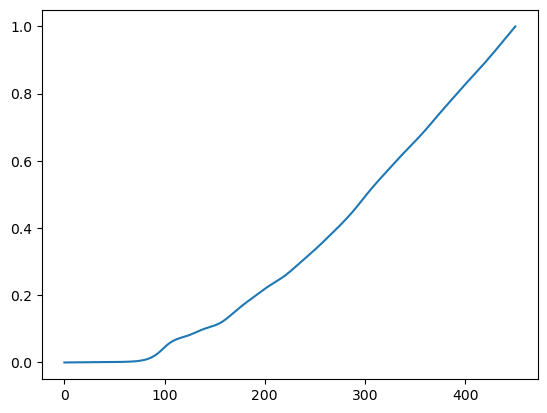

model accuracy (R^2) on simulated test data 0.8059453654840871
0.2757742521232258


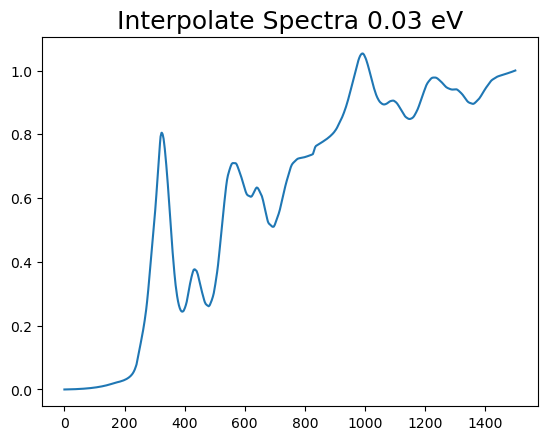

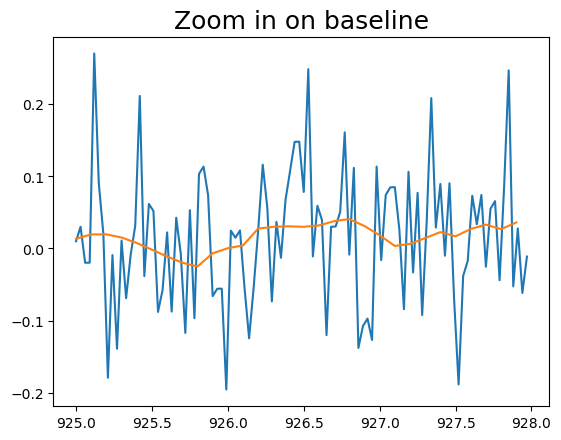

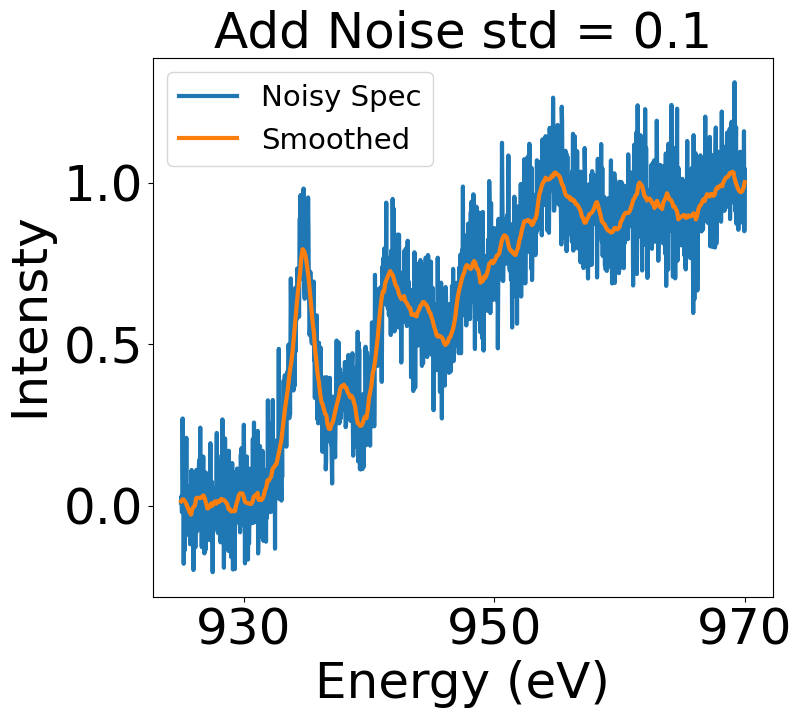

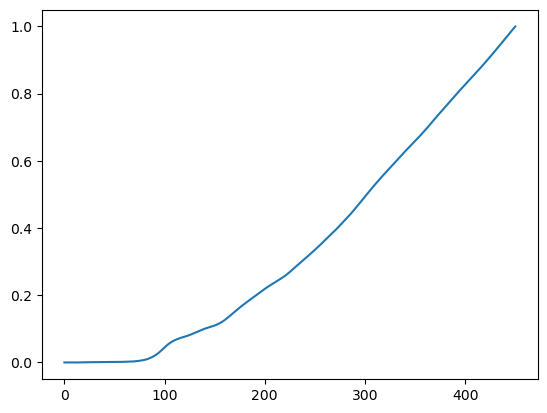

model accuracy (R^2) on simulated test data 0.7890828607728448
0.2875064829165312


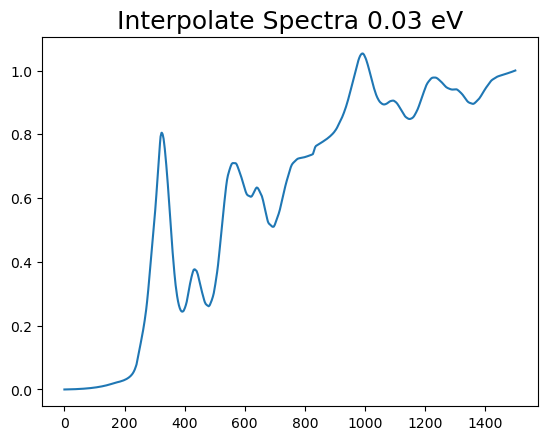

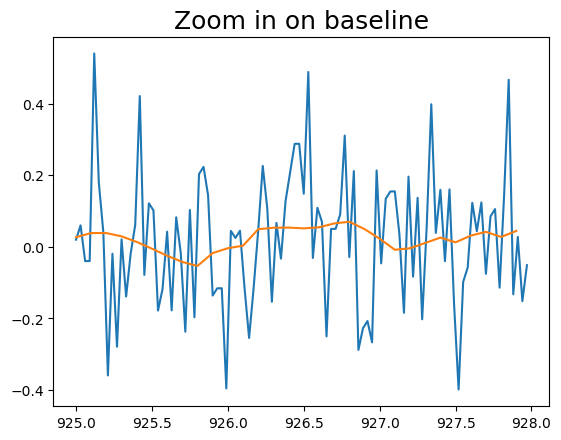

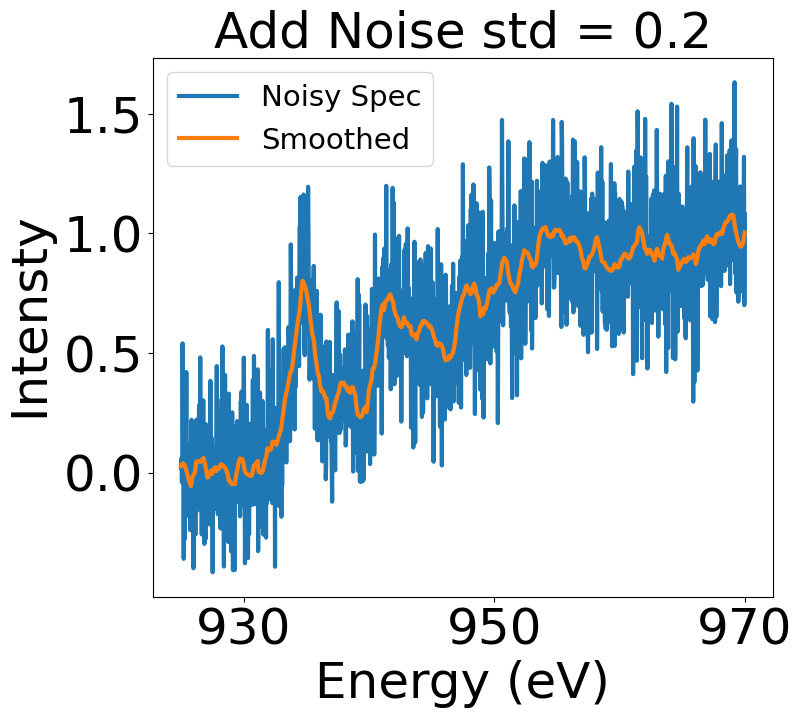

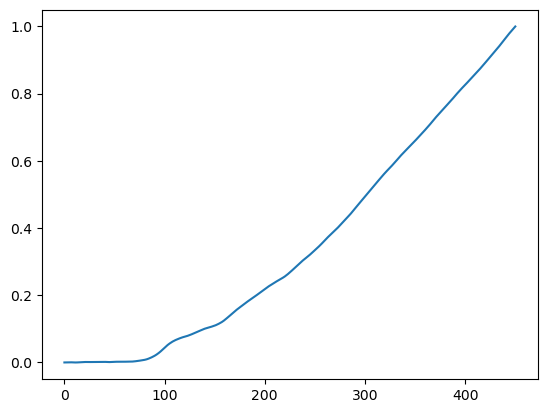

model accuracy (R^2) on simulated test data 0.7780883325867132
0.29490475438184355
1
model accuracy (R^2) on simulated test data 0.7925392999028698
0.28514097181757586
model accuracy (R^2) on simulated test data 0.6087356193286875
0.3915857348257637
model accuracy (R^2) on simulated test data 0.5691991961477062
0.4108941502037237
model accuracy (R^2) on simulated test data 0.5456881355077668
0.4219575336586326
2
model accuracy (R^2) on simulated test data 0.8210358502966415
0.26483460154787963
model accuracy (R^2) on simulated test data 0.6346246330383707
0.3784088964156061
model accuracy (R^2) on simulated test data 0.5811271732574531
0.40516581881610175
model accuracy (R^2) on simulated test data 0.5404961295404727
0.42436180969337917
3
model accuracy (R^2) on simulated test data 0.7128773721029248
0.33544816151127915
model accuracy (R^2) on simulated test data 0.4971985140359072
0.4439049441109991
model accuracy (R^2) on simulated test data 0.4595381738578532
0.46022925117300983
mod

In [58]:
# generate full simulated noise analysis. This takes a very long time to run 
test_rf_obj.full_noise_setup('Interpolated_spec_0.03', 'Interpolated_spec_energies_0.03', 0.03, 51, 
                             filename='Dataset_generation/reproducable_alignment_model_full_noise_df_poisson_03.joblib',
                            show_plots = True)

In [30]:
# load the values generated by the cell above 
poisson_noise_df_03 = joblib.load('Dataset_generation/BUG_FIXED_reproducable_alignment_model_full_noise_df_poisson_03.joblib')

R2s
0.7620922440387122 0.707940159862977 0.6822135321841841 0.6320280410261636
RMSEs
0.30027906294406603 0.3319158880940154 0.3466050503403884 0.37359246657414047


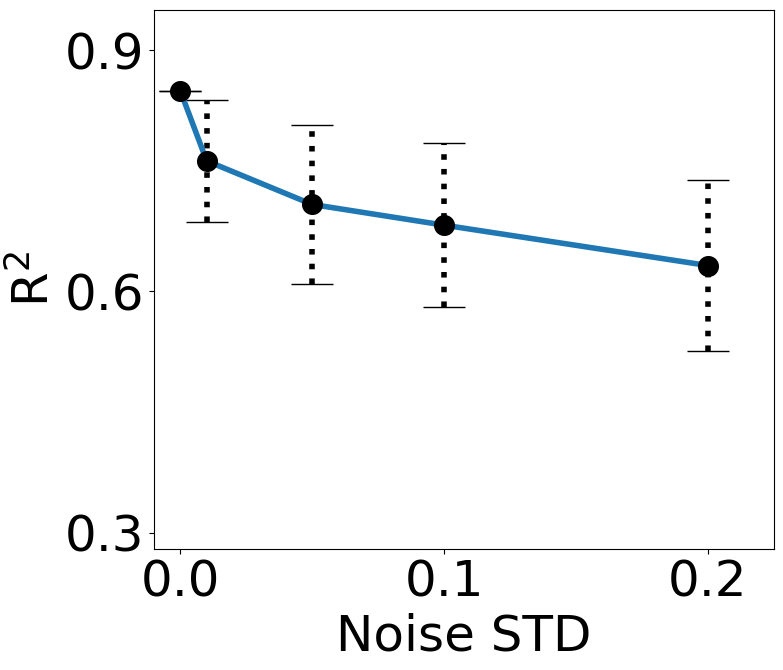

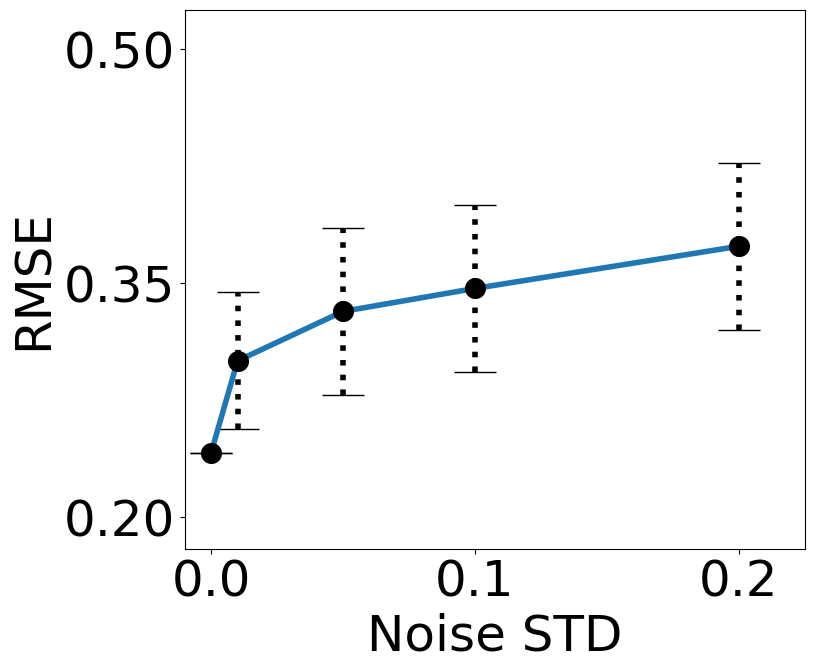

In [31]:
# plot the change in accuracy across different volumes of noise, with dotted bars showing standard deviation across 100 random 
# seeds for the noise profile generation 
visualize_full_noise_test_set([poisson_noise_df_03], [0.03], savefigure=False, top_line_accuracy = [test_rf_obj.accuracy, test_rf_obj.rmse])

<font size="6"> Comparison between literature XAS and simulated XAS spectra for Cu metal, Cu2O and CuO. Figure S1

In [32]:
Cu_metal_path = "xas paper/Cu Metal XAS.csv"
Cu2O_path = "xas paper/Cu2O XAS.csv"
CuO_path = "xas paper/CuO XAS.csv"

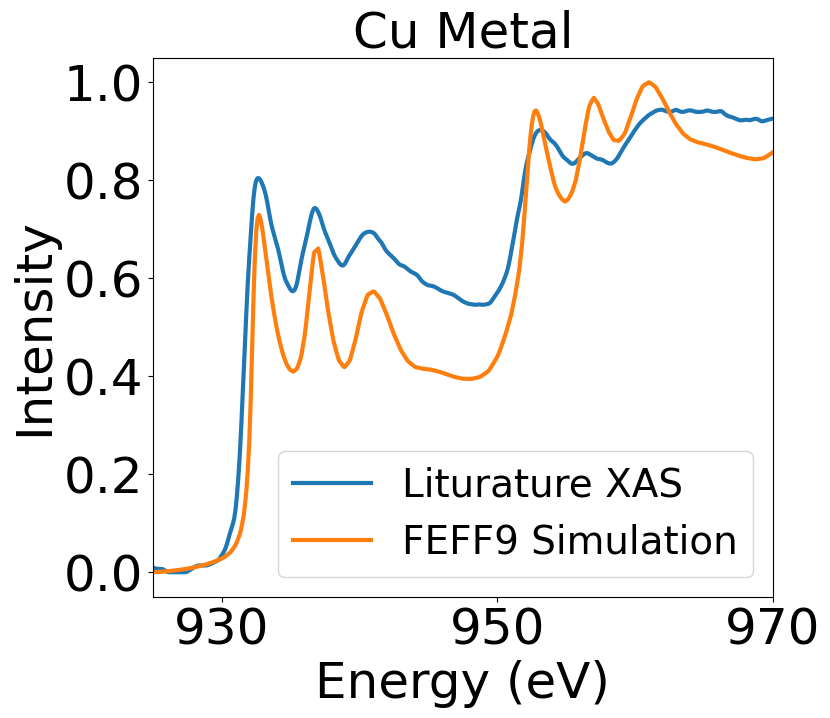

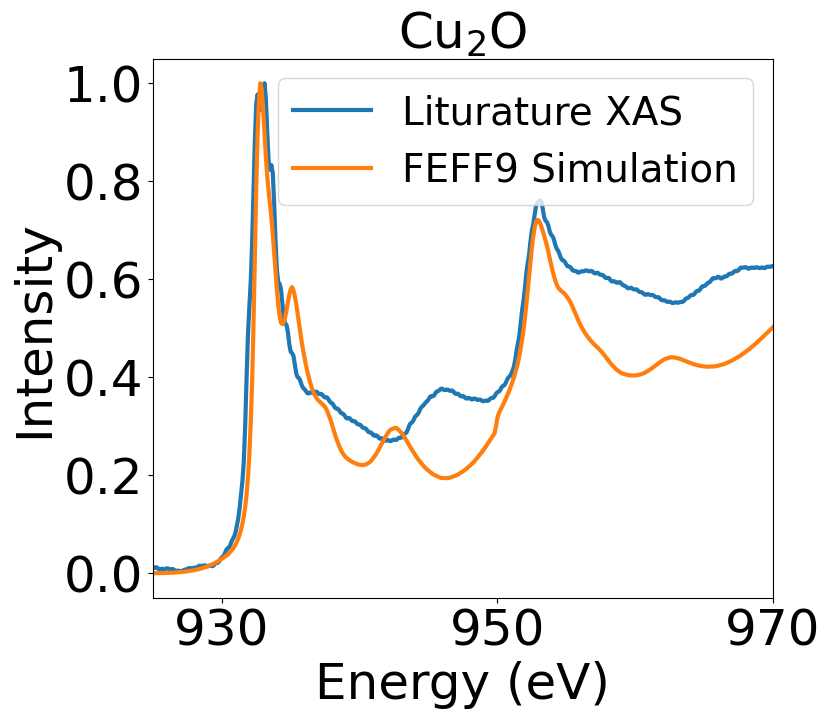

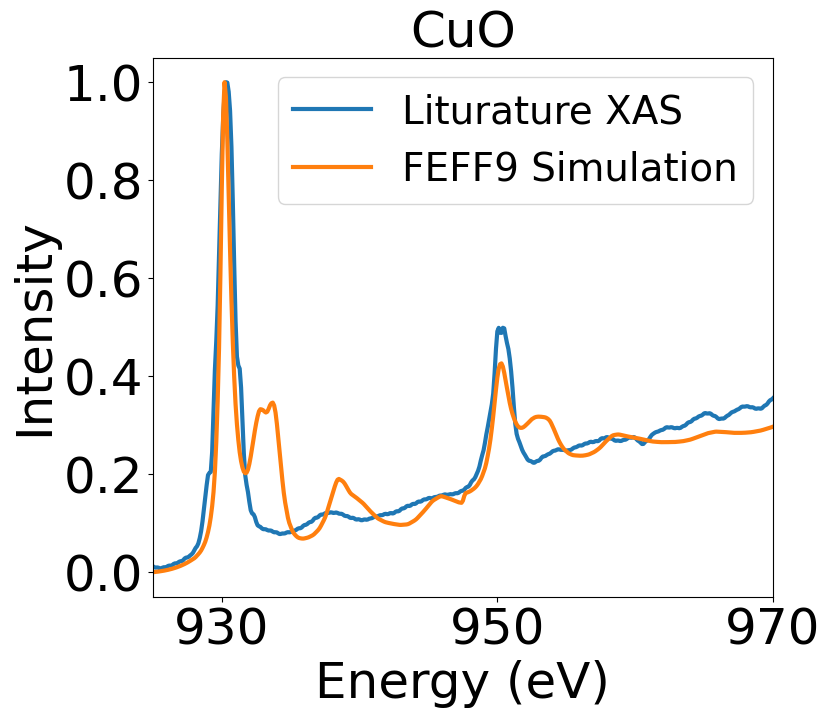

In [34]:
test_rf_obj.compare_simulation_to_experiment(show_feff = True, feff_shift = 0, material = 'Cu metal',
                           compare_to_lit = True, lit_spectrum = Cu_metal_path, lit_shift = -1.0, xlims = [925,970],
                            title = 'Cu Metal', show_experiment = False, savefigure=False)

test_rf_obj.compare_simulation_to_experiment(show_feff = True, feff_shift = 0, material = 'Cu2O',
                           compare_to_lit = True, lit_spectrum = Cu2O_path, lit_shift = -1.2, xlims = [925,970],
                            title = 'Cu$_2$O', show_experiment = False, savefigure=False)


test_rf_obj.compare_simulation_to_experiment(show_feff = True, feff_shift = 0,
                           compare_to_lit = True, lit_spectrum = CuO_path, lit_shift = -1.2, xlims = [925,970],
                            title = 'CuO', show_experiment = False, material = 'CuO',
                                            savefigure=False)

<font size="6"> Illustration of L2 and L3 Combination Into L2,3. Figure S2

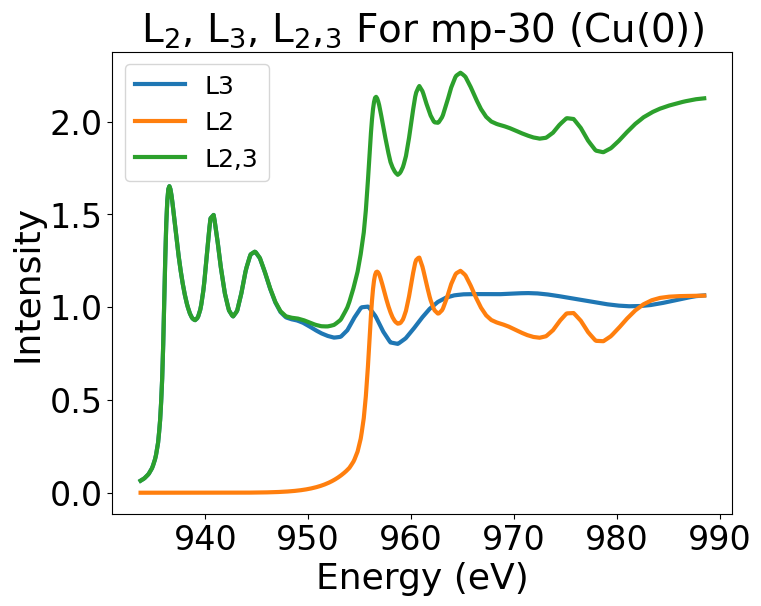

In [35]:
l2 = np.loadtxt('C:/Users/smgls/Materials_database/Stable_and_exp_Cu/Stable_and_exp_Cu/Stable_Cu_L2/mp-30/FEFF/000_Cu/xmu.dat',usecols=[0,3])
l3 = np.loadtxt('C:/Users/smgls/Materials_database/Stable_and_exp_Cu/Stable_and_exp_Cu/Stable_Cu_L3//mp-30/FEFF/000_Cu/xmu.dat',usecols=[0,3])

l2_3 = build_L2_3(l3, l2, savefigure=False)

<font size="6"> Illustration of The Generation of The Standardized Pre Edge Region Ensuring All Spectra Start at the same point and at Zero Intensity. Figure S3

interp min = 933.8


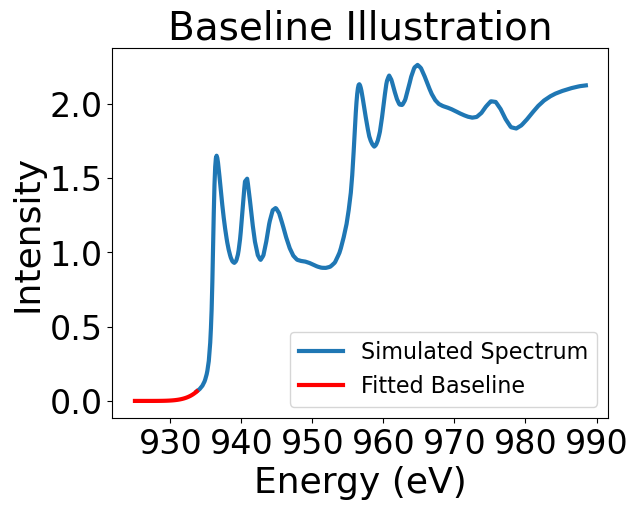

In [36]:
with open('scaled_baseline_example.pkl', 'rb') as f:
    ex_df = pickle.load(f)

ex_df = scale_spectra_flex(ex_df.loc[ex_df.mp_id == 'mp-30'], zero_energy = 925, show_plot=True, savefigure=False)

<font size="6"> Standard Deviation Thresholds. Figure S6

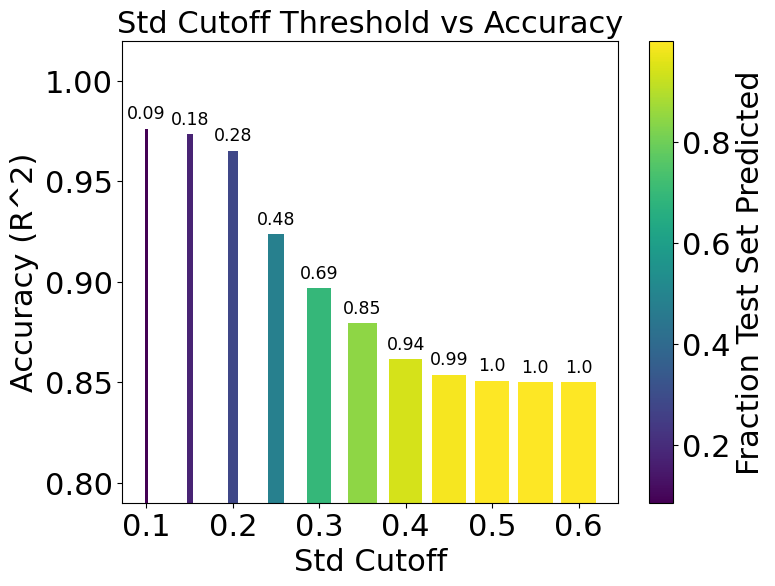

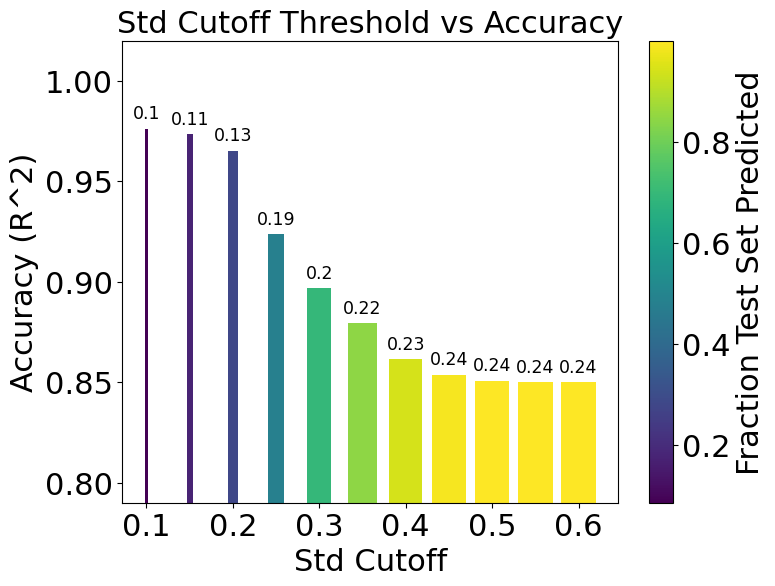

In [37]:
thresholds = np.arange(0.1, 0.65, 0.05)
test_rf_obj.visualize_all_thresholds(thresholds, ylims = [0.79, 1.02], text_fontsize = 12.5, show_type = 'percentage_predicted', 
                                    color_scheme = 'viridis', yticks_to_use = [0.8, 0.85, 0.9, 0.95, 1.0], savefigure=True)
test_rf_obj.visualize_all_thresholds(thresholds, ylims = [0.79, 1.02], text_fontsize = 12.5, show_type = 'RMSE', 
                                    color_scheme = 'viridis', yticks_to_use = [0.8, 0.85, 0.9, 0.95, 1.0], savefigure=True)

<font size="6"> Full Experimental Workflow. Figure S7

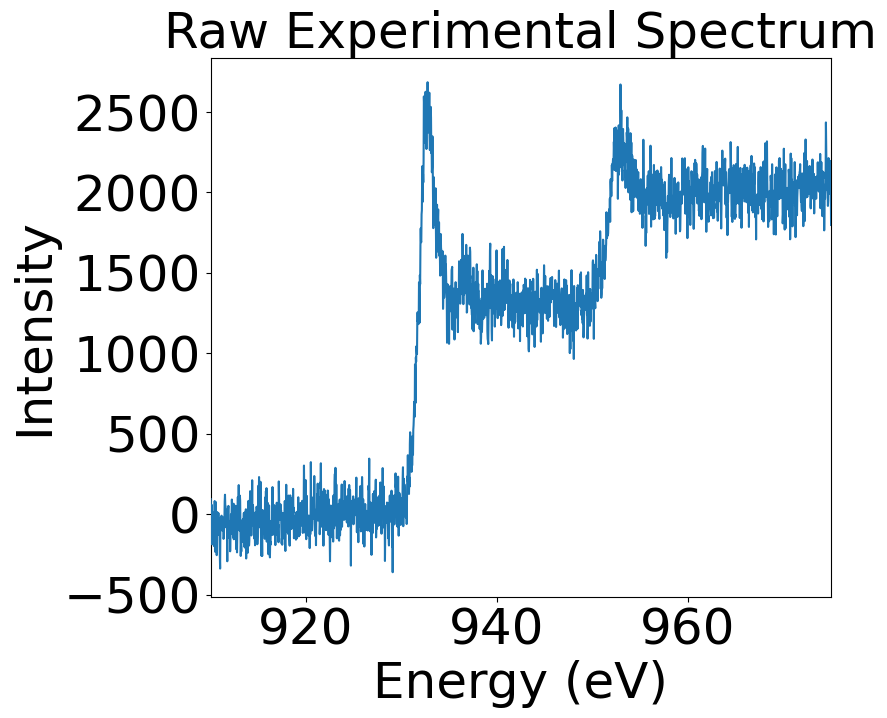

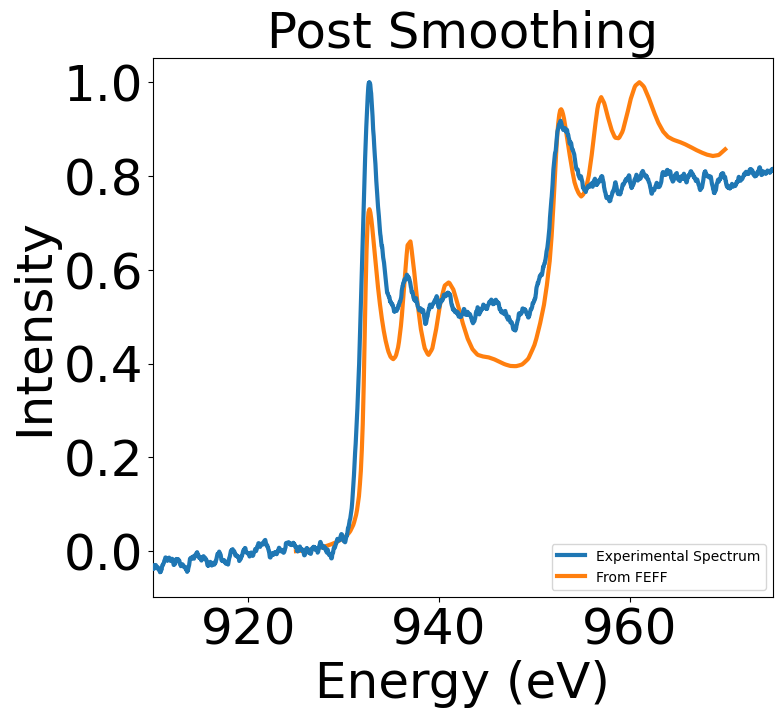

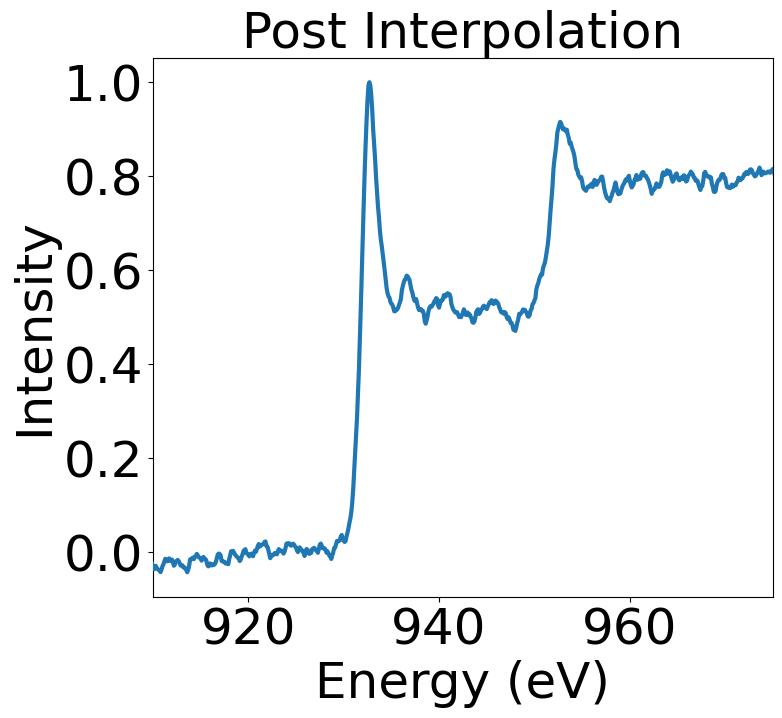

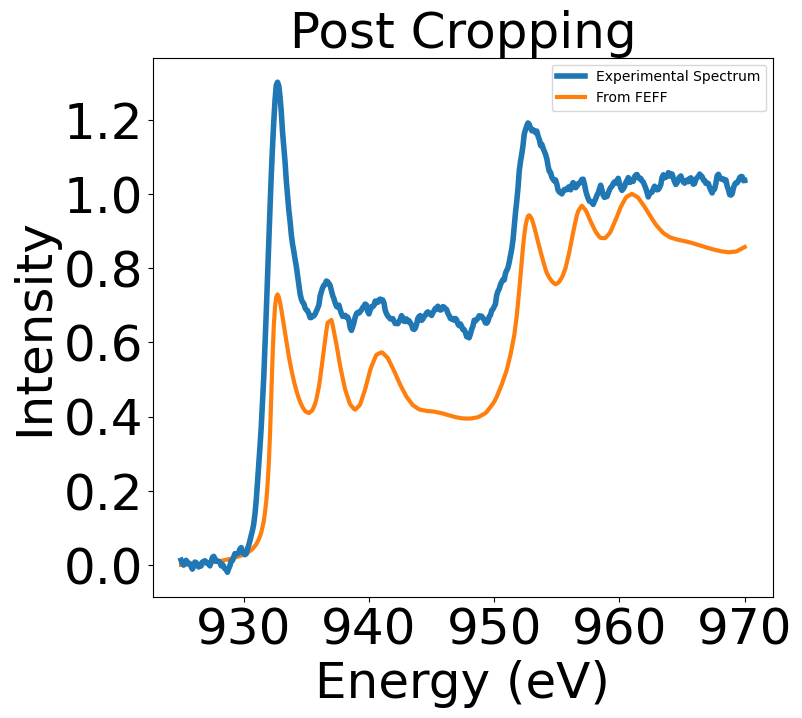

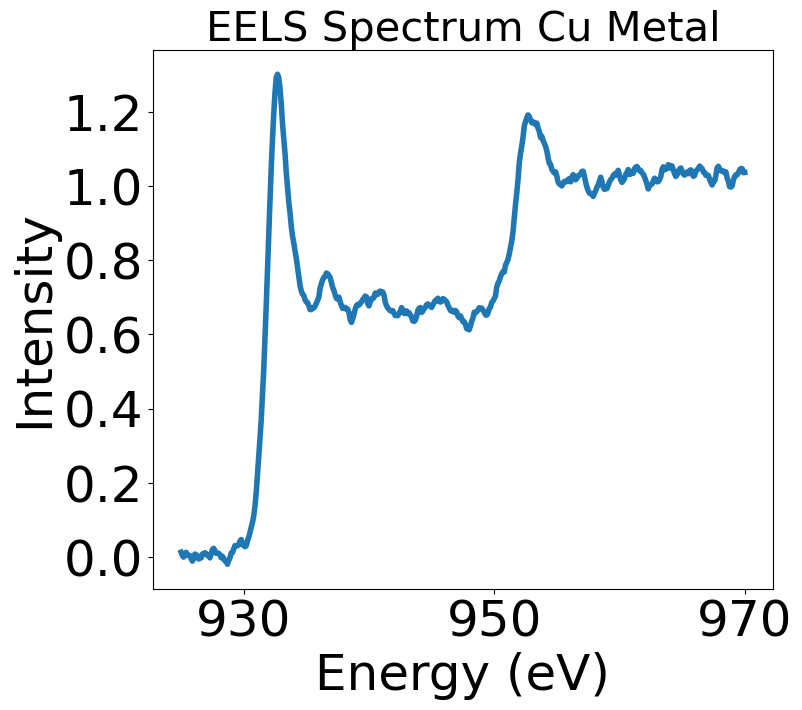

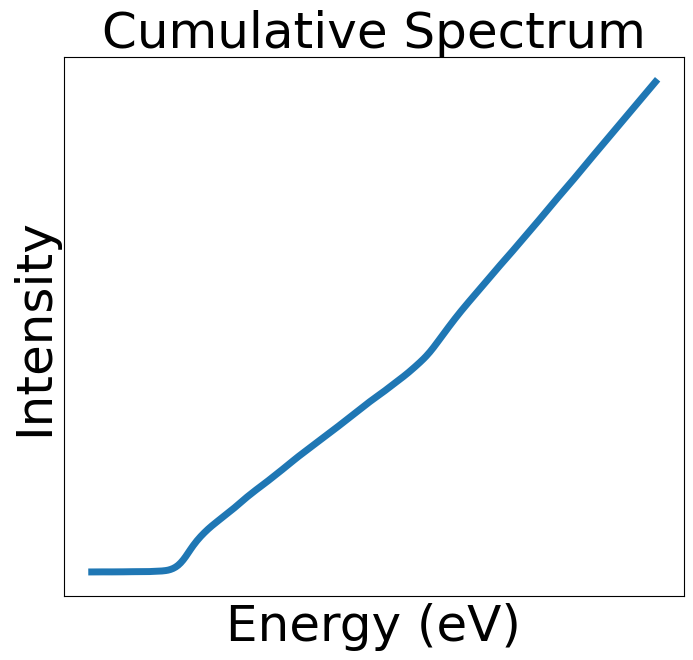

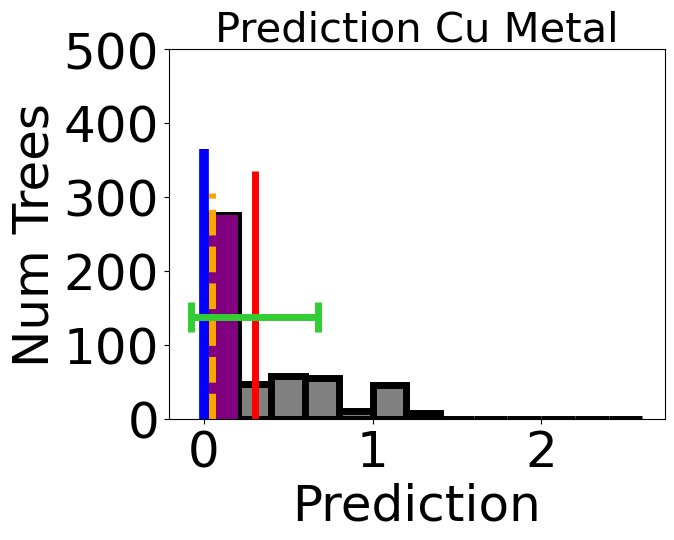

Prediction Mode = 0.1
Prediction Median = 0.05
Prediction = 0.3
Prediction Std = 0.38
 


In [46]:
test_rf_obj.predict_experiment_random_forest('C:/Users/smgls/Materials_database/Cu_deconvolved_spectra/Cu Metal Deconvolved Spectrum.dm4',
                                             1644, 'Cu Metal', exp_spectrum_type='TEAM I',
                                            smoothing_parms=[51,3], points_to_average=10, cumulative_spectrum=True,
                                            spectrum_energy_shift=0.0, theory_column='TEAM_1_aligned_925_970', 
                                            energies_range=[925,970], show_hist=True, show_plots=True, show_inputted_spectrum = True,
                                            savefigure=False, check_alignment = True)

<font size="6"> Experimental EELS vs Literature XAS Cu Metal and Cu2O. Figure S8

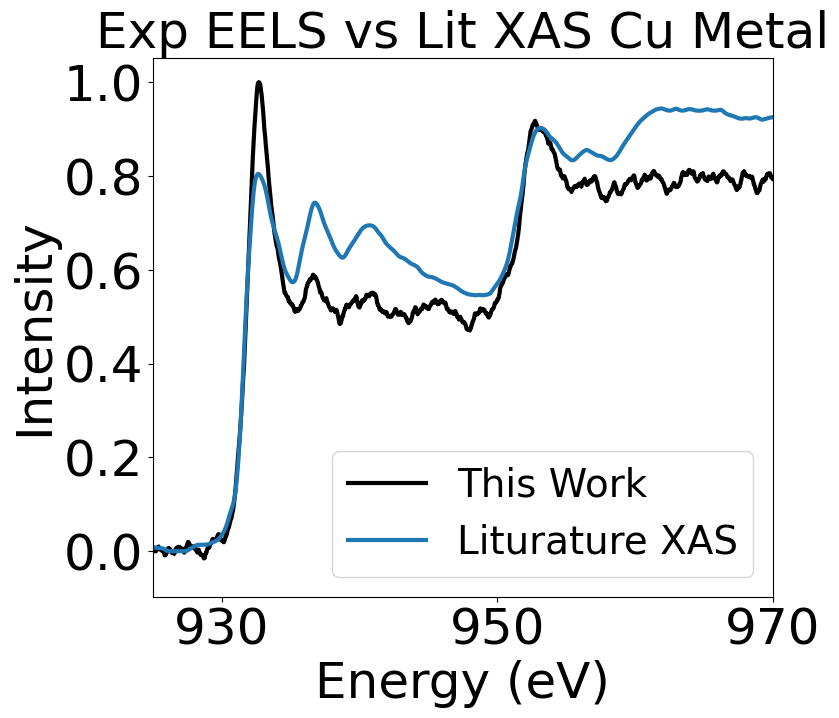

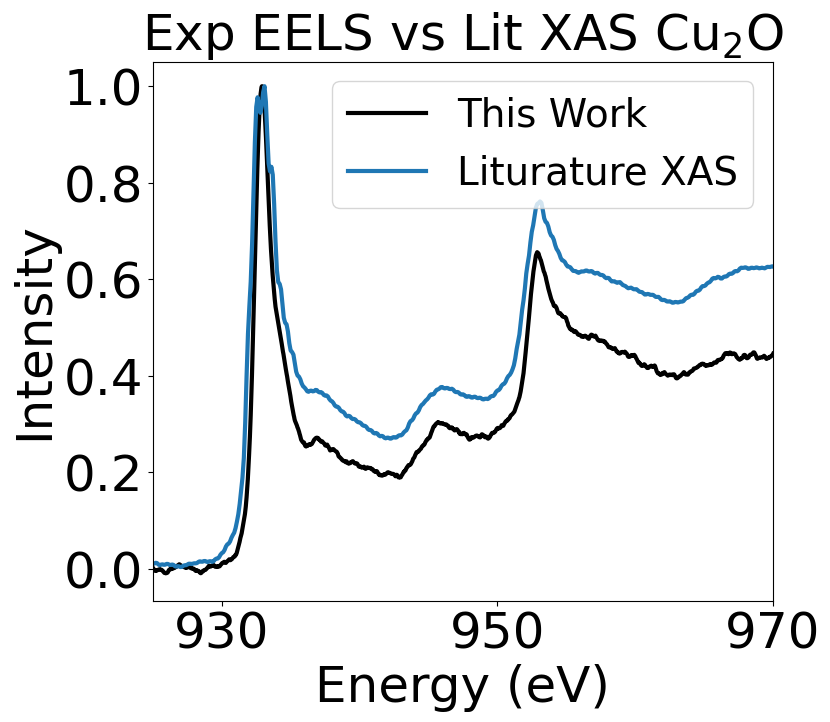

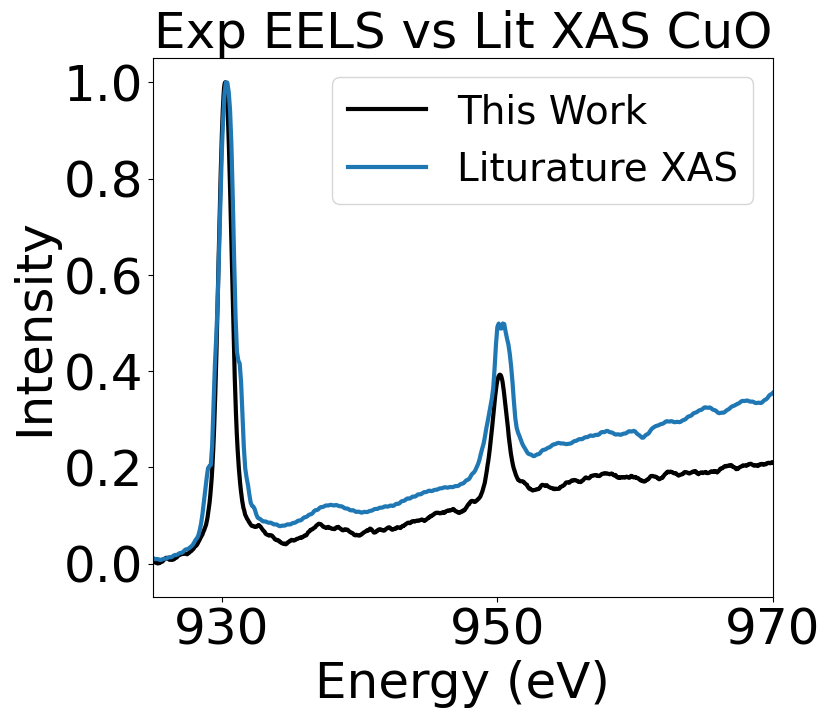

In [73]:
test_rf_obj.compare_simulation_to_experiment(show_feff = False, feff_shift = 0, material = 'Cu metal',
                           compare_to_lit = True, lit_spectrum = Cu_metal_path, lit_shift = -1.0, xlims = [925,970],
                            title = 'Exp EELS vs Lit XAS Cu Metal', show_experiment = True, savefigure=False)


test_rf_obj.compare_simulation_to_experiment(show_feff = False, feff_shift = 0, material = 'Cu2O',
                           compare_to_lit = True, lit_spectrum = Cu2O_path, lit_shift = -1.2, xlims = [925,970],
                            title = 'Exp EELS vs Lit XAS Cu$_2$O', show_experiment = True, savefigure=False)

test_rf_obj.compare_simulation_to_experiment(show_feff = False, feff_shift = 0, material = 'CuO',
                           compare_to_lit = True, lit_spectrum = CuO_path, lit_shift = -1.2, xlims = [925,970],
                            title = 'Exp EELS vs Lit XAS CuO', show_experiment = True, savefigure=False)

<font size="6"> Simulated Mixture Spectra, Mixtures of Cu metal, Cu2O and CuO. Figure S9

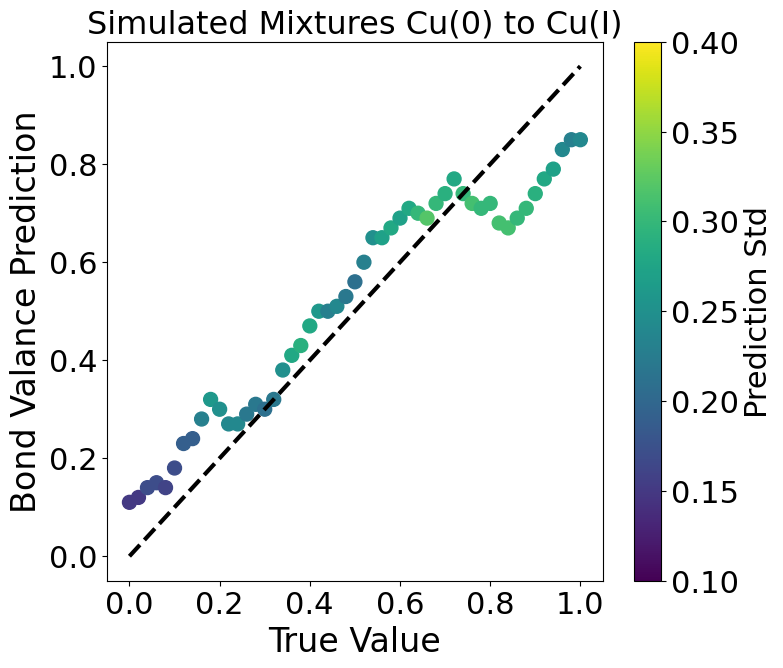

In [74]:
test_rf_obj.simulated_mixed_valent(catagory = '0-1', savefigure=True, colorbar_range = [0.1, 0.4])

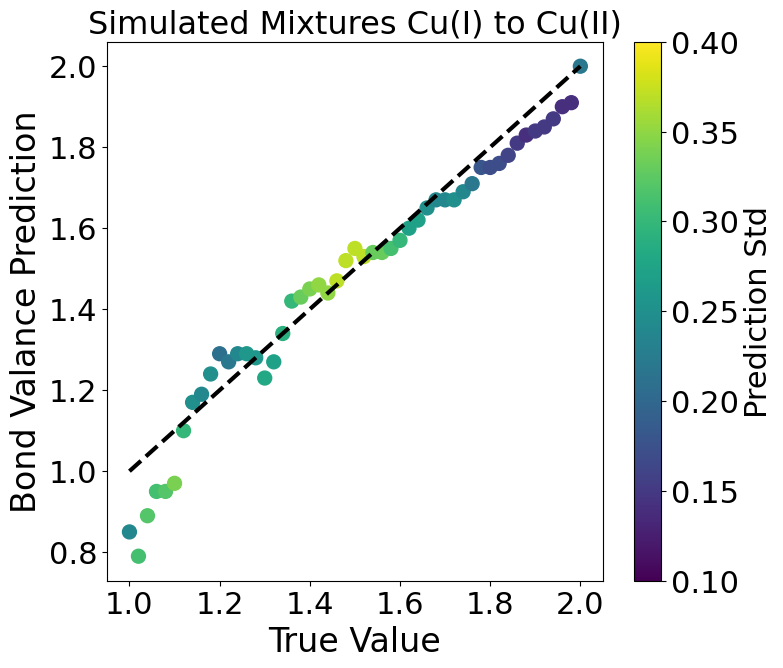

In [75]:
test_rf_obj.simulated_mixed_valent(catagory = '1-2', savefigure=True, colorbar_range = [0.1, 0.4])

<font size="6"> Impact of Smoothing on Experimental EELS Spectra Predictions. Figure S10

In [76]:
smoothings = [[5,3], [21,3], [35,3], [51,3], [75,3], [101,3], [125,3], [151,3]]

In [77]:
test_rf_obj.predict_experiment_folder('Cu_deconvolved_spectra/', spectra_type = 'TEAM I', show_plots=False,
                                      shifts = [0.0], theory_column = 'TEAM_1_aligned_925_970', smoothings = smoothings, 
                                      show_hist=False, show_inputted_spectrum=False, savefigure=False, print_details=False,
                                     theory_indicies = [1644, 2246, 824])

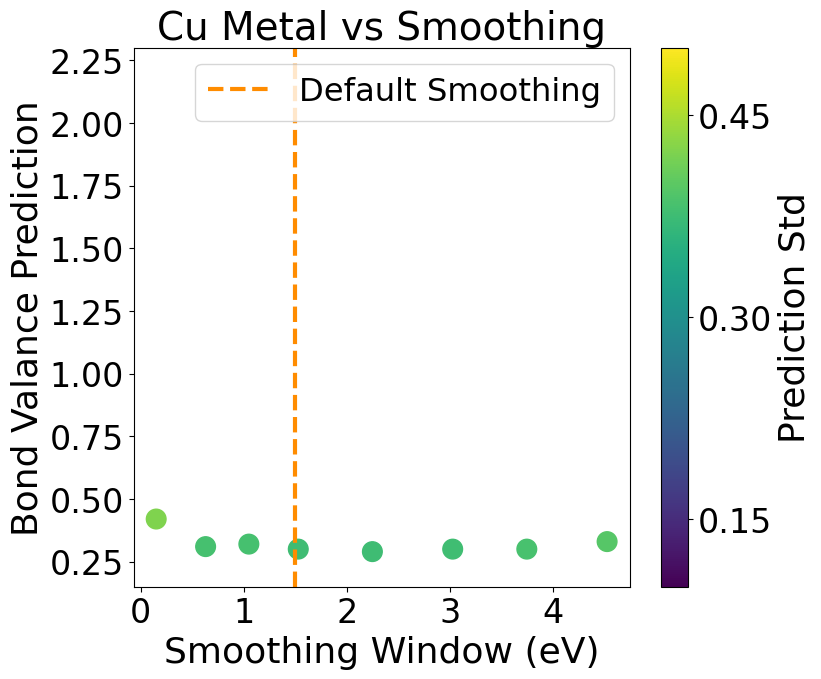

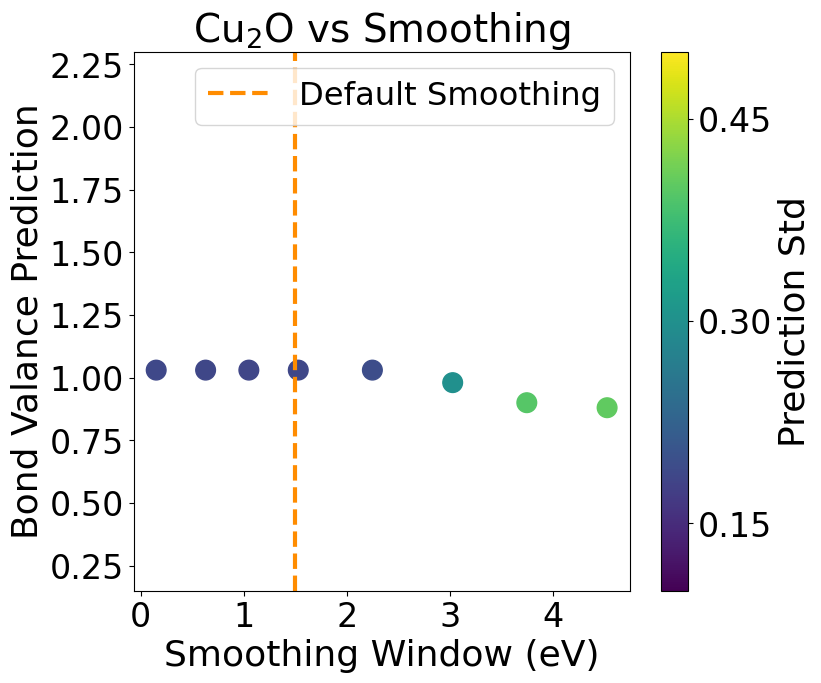

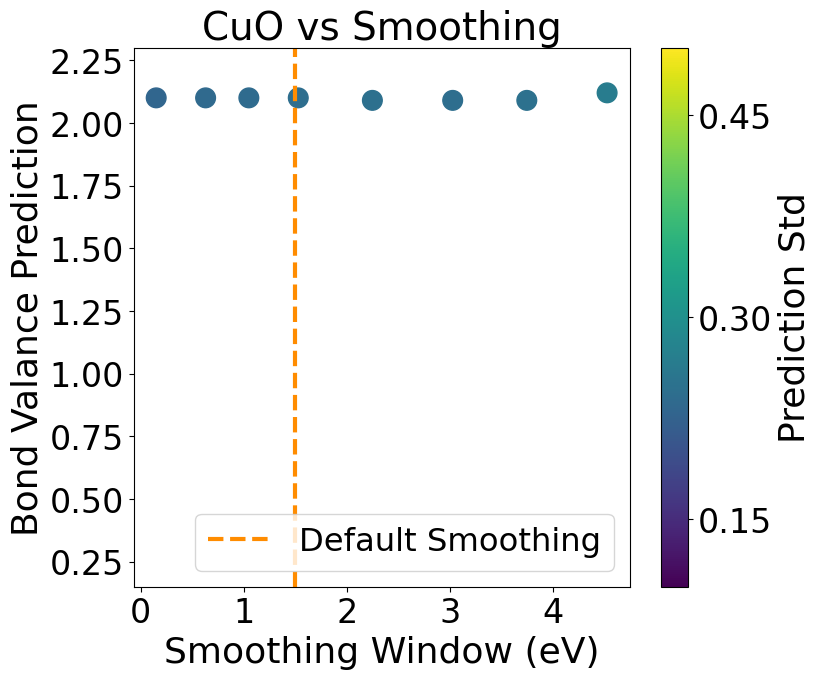

In [78]:
test_rf_obj.visualize_smoothings(show_table=False, savefigure=True)

<font size="6"> Spectral Alignment Examples Figure S11

found in "Full_spectral_alignment" notebook

<font size="6"> Additional Experimental Examples Figure S12 and S13

In [87]:
alignments = {
    'LaCuSO':-2.4,
    'LaCuSeO':-2.4,
    'LaCuTeO':-2.6,
    'ZrCuSiAs':-2,
    'ZrCuSiP':-2,
    'CuS':-2,
    'CuFeS2':0.5,
    'Cu2S':-1.8,
}

theory_indicies = {
    'LaCuSO':2294,
    'LaCuSeO':2433,
    'LaCuTeO':591,
    'ZrCuSiAs':2014,
    'ZrCuSiP':2152,
    'CuS':2488,
    'CuFeS2':2553,
    'Cu2S':745,
}
alignments

{'LaCuSO': -2.4,
 'LaCuSeO': -2.4,
 'LaCuTeO': -2.6,
 'ZrCuSiAs': -2,
 'ZrCuSiP': -2,
 'CuS': -2,
 'CuFeS2': 0.5,
 'Cu2S': -1.8}

LaCuSO
Predicting From LaCuSO\LaCuSO.csv
Energy Axis Shift = -2.4
Smoothing Parameters = [15, 3]


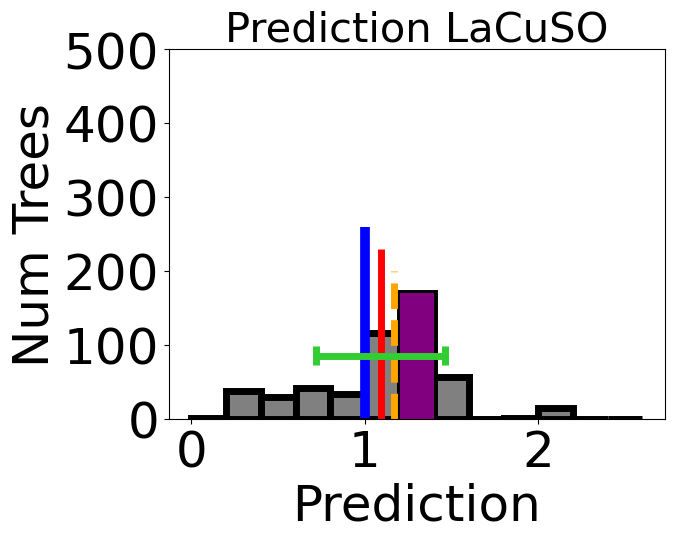

Prediction Mode = 1.3
Prediction Median = 1.17
Prediction = 1.09
Prediction Std = 0.37
 
LaCuSeO
Predicting From LaCuSeO\LaCuSeO.csv
Energy Axis Shift = -2.4
Smoothing Parameters = [15, 3]


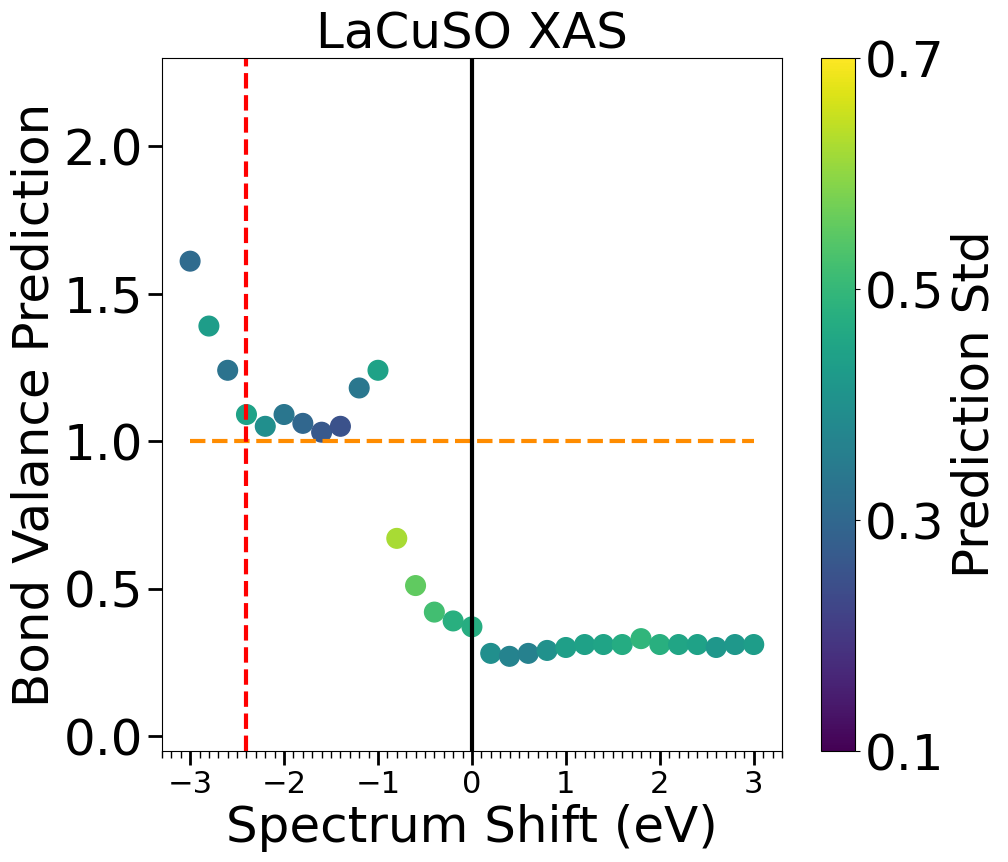

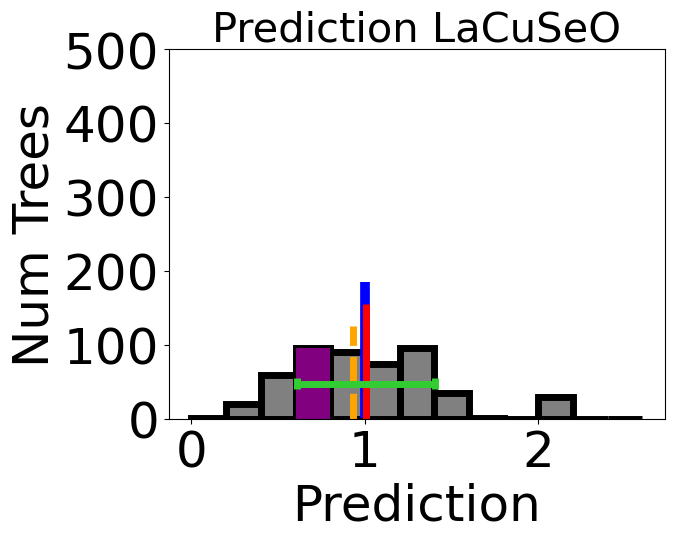

Prediction Mode = 0.7
Prediction Median = 0.93
Prediction = 1.01
Prediction Std = 0.4
 
LaCuTeO
Predicting From LaCuTeO\LaCuTeO.csv
Energy Axis Shift = -2.6
Smoothing Parameters = [15, 3]


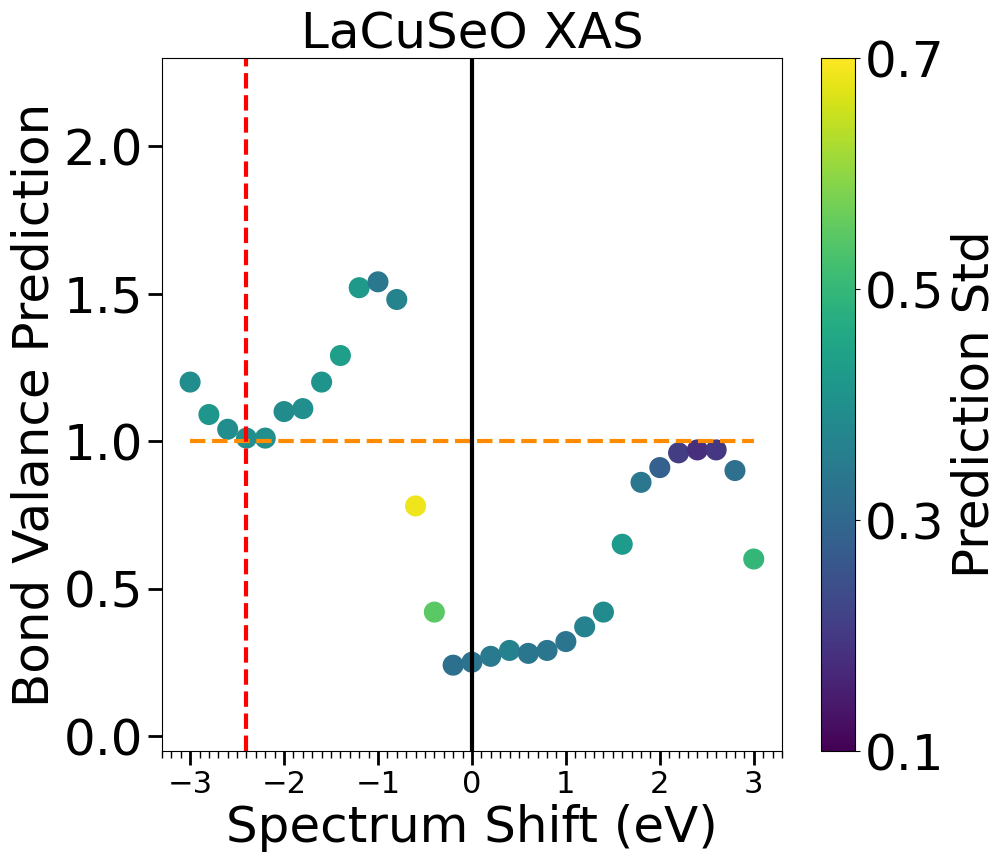

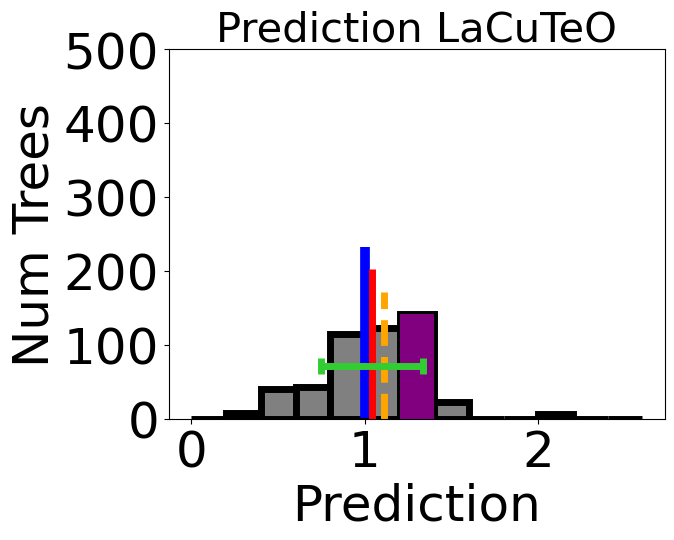

Prediction Mode = 1.3
Prediction Median = 1.11
Prediction = 1.04
Prediction Std = 0.29
 
ZrCuSiAs
Predicting From ZrCuSiAs\ZrCuSiAs.csv
Energy Axis Shift = -2
Smoothing Parameters = [15, 3]


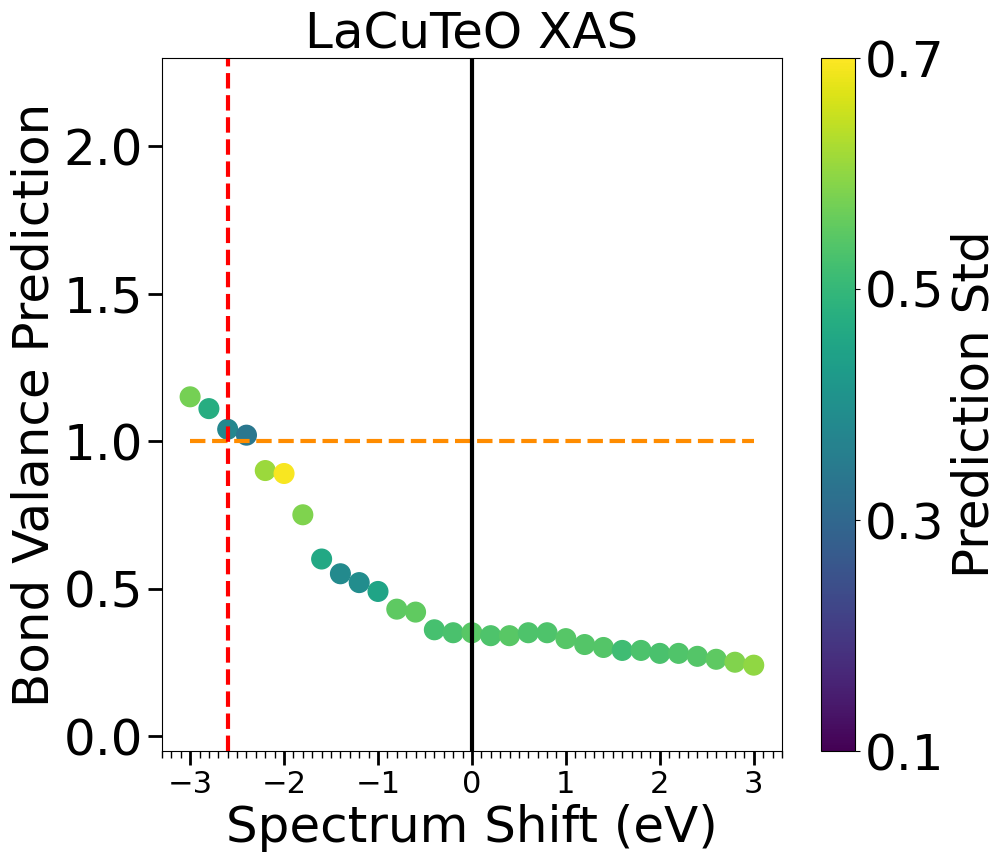

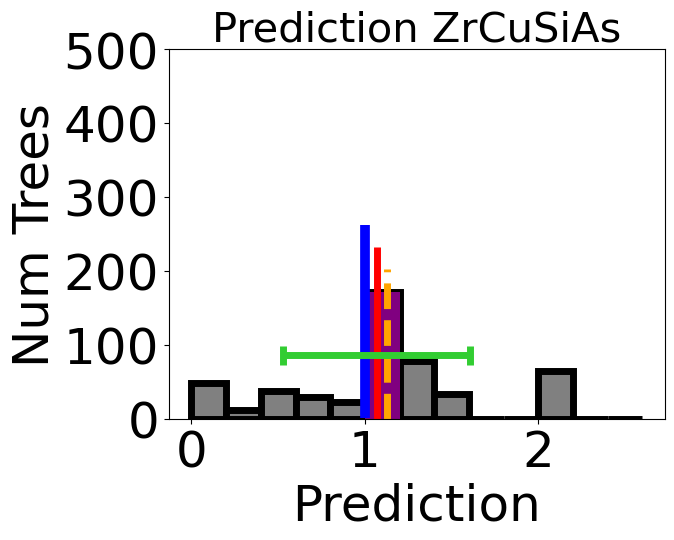

Prediction Mode = 1.1
Prediction Median = 1.13
Prediction = 1.07
Prediction Std = 0.54
 
ZrCuSiP
Predicting From ZrCuSiP\ZrCuSiP.csv
Energy Axis Shift = -2
Smoothing Parameters = [15, 3]


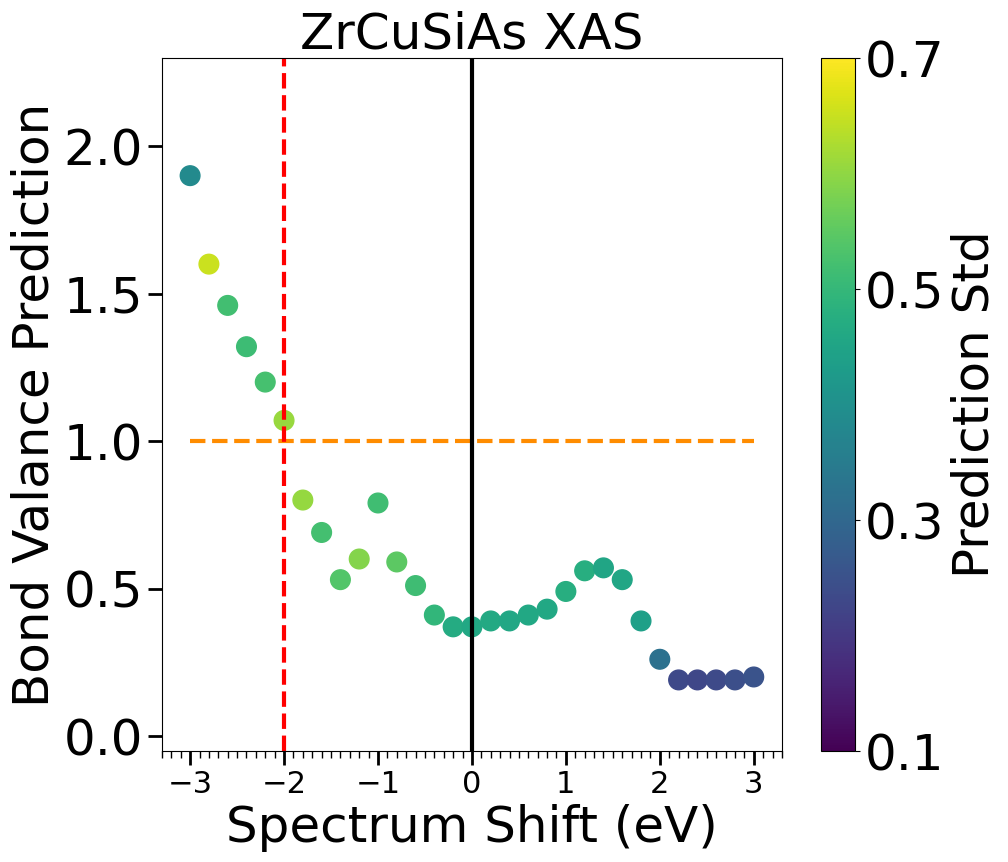

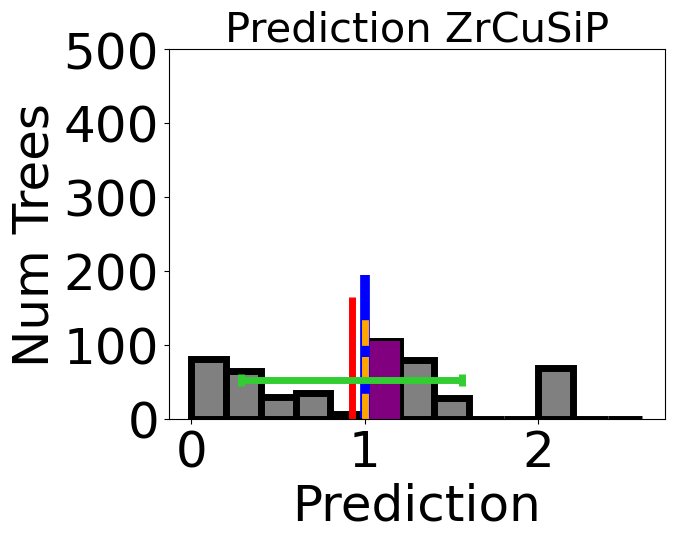

Prediction Mode = 1.1
Prediction Median = 1.0
Prediction = 0.92
Prediction Std = 0.64
 
CuS
Predicting From CuS\CuS.csv
Energy Axis Shift = -2
Smoothing Parameters = [15, 3]


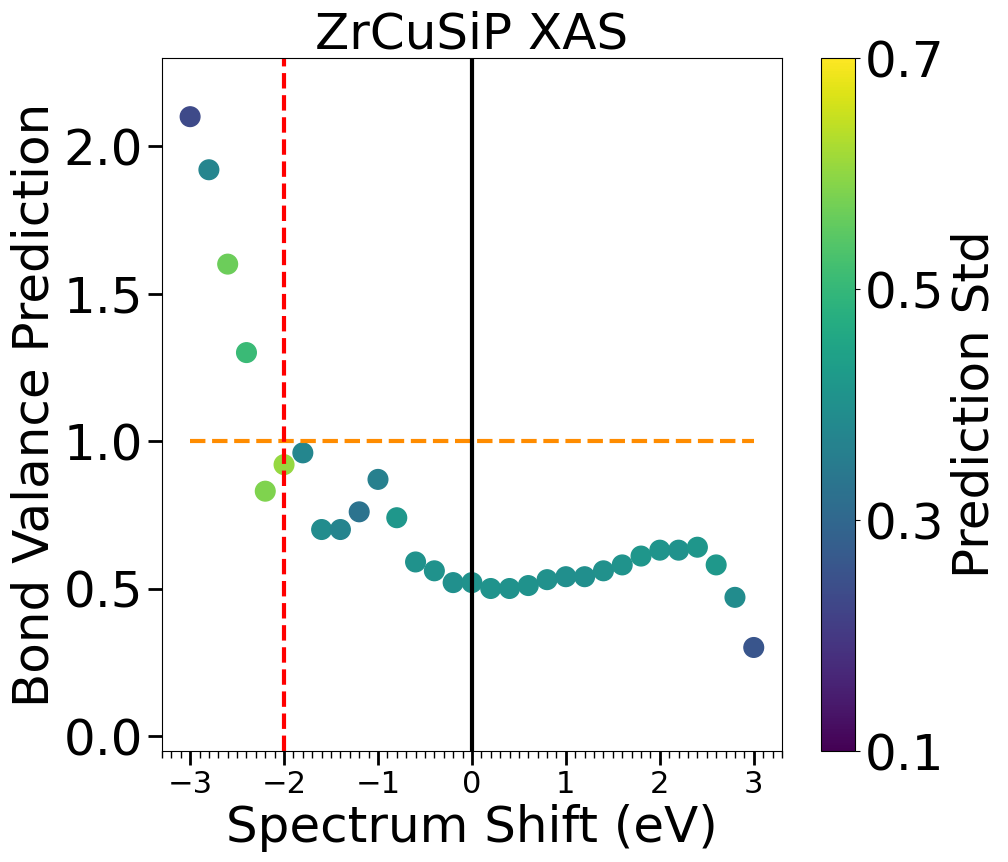

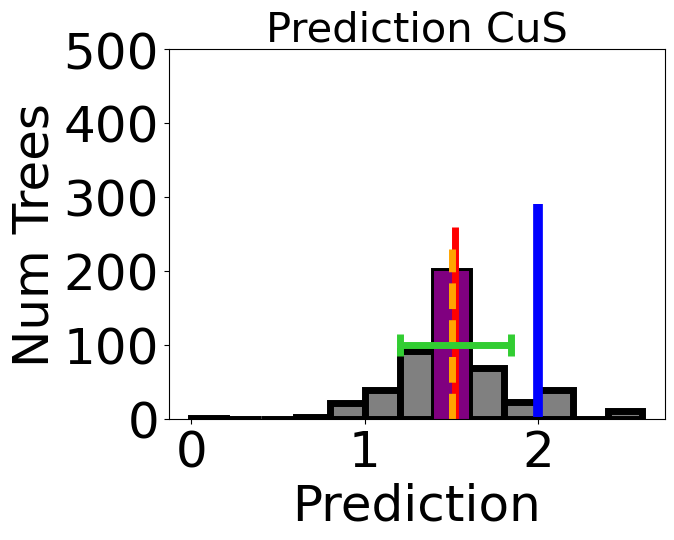

Prediction Mode = 1.5
Prediction Median = 1.5
Prediction = 1.52
Prediction Std = 0.32
 
CuFeS2
Predicting From CuFeS2\CuFeS2.csv
Energy Axis Shift = 0.5
Smoothing Parameters = [15, 3]


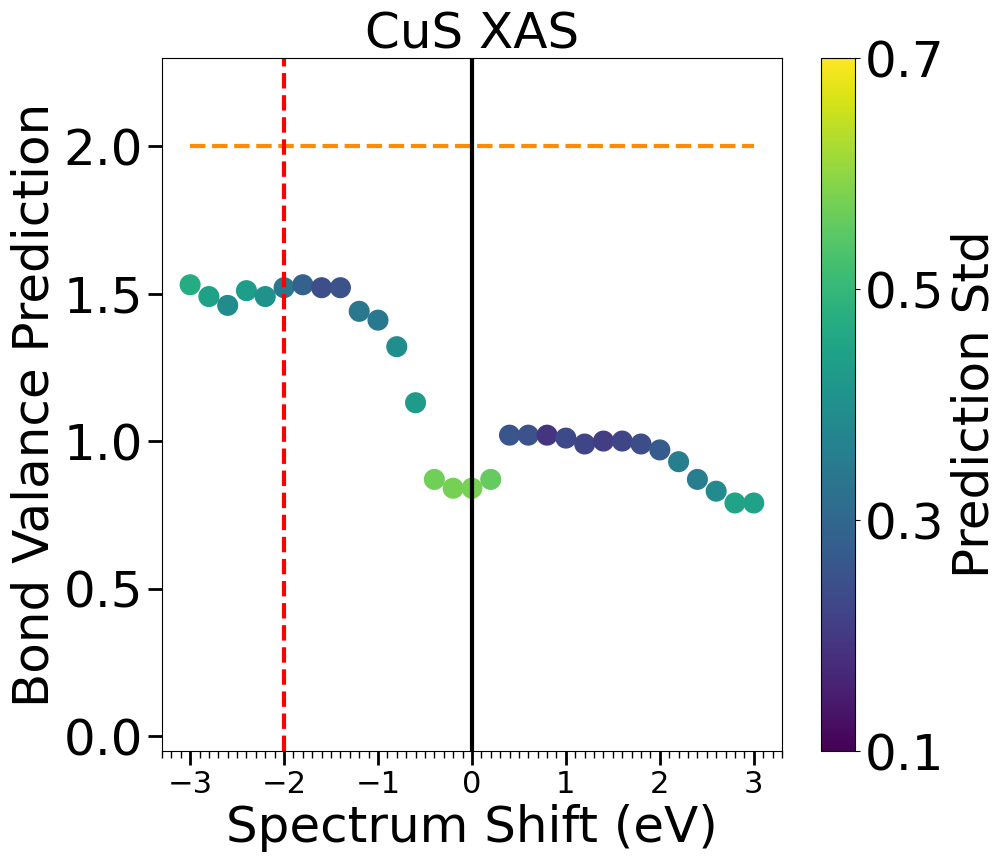

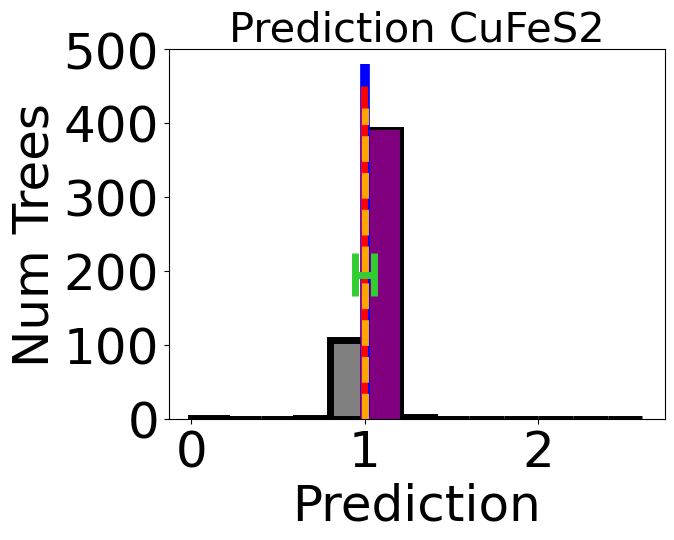

Prediction Mode = 1.1
Prediction Median = 1.0
Prediction = 1.0
Prediction Std = 0.05
 
Cu2S
Predicting From Cu2S\Cu2S.csv
Energy Axis Shift = -1.8
Smoothing Parameters = [15, 3]


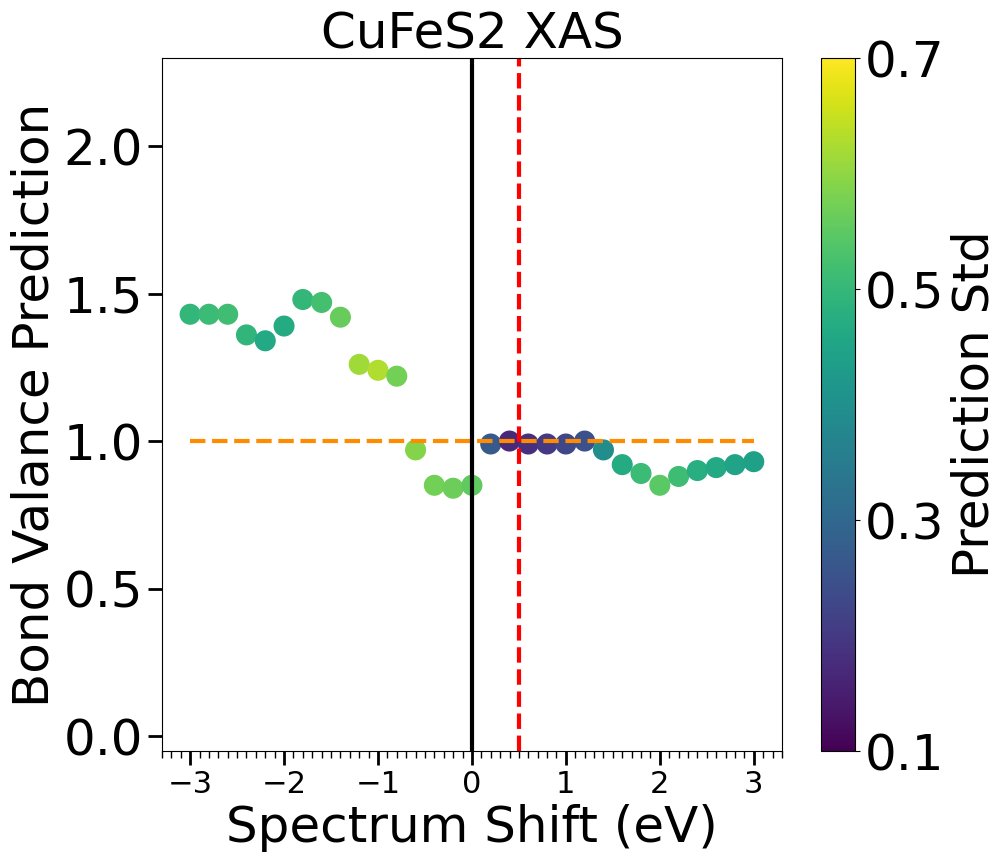

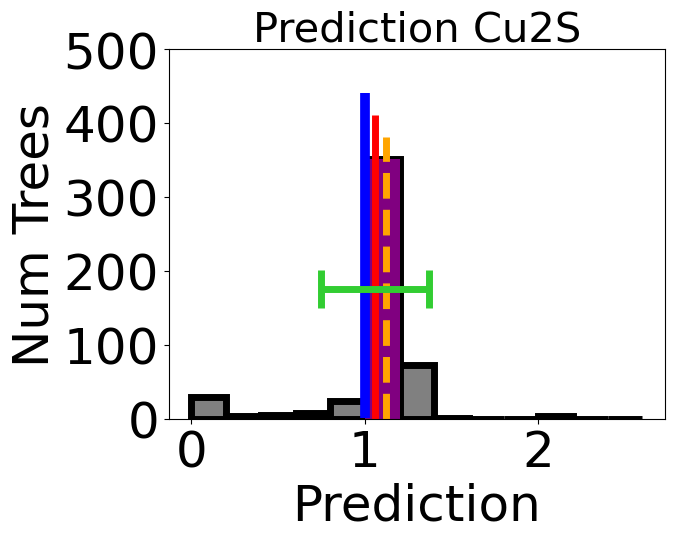

Prediction Mode = 1.1
Prediction Median = 1.12
Prediction = 1.06
Prediction Std = 0.31
 


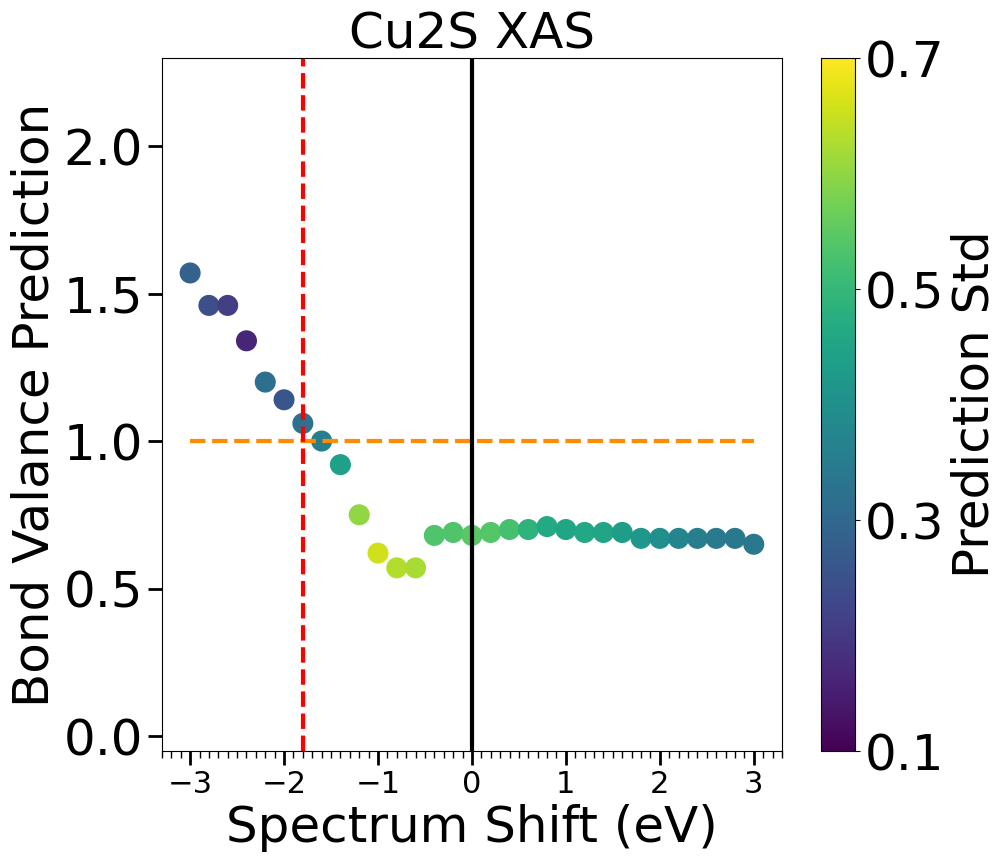

In [89]:
shifts = np.linspace(-3, 3, 31)
for mat in theory_indicies.keys():
    print(mat)

    test_rf_obj.predict_experiment_folder(mat+'/', spectra_type = 'csv', 
                                          shifts = [alignments[mat]], theory_column = 'TEAM_1_aligned_925_970', smoothings = [[15,3]], 
                                          show_hist=True, show_inputted_spectrum=False, print_details = True, show_plots=False, check_alignment = False,
                                         savefigure=False, theory_indicies = [theory_indicies[mat]])
    

    test_rf_obj.predict_experiment_folder(mat+'/', spectra_type = 'csv', 
                                          shifts = shifts, theory_column = 'TEAM_1_aligned_925_970', smoothings = [[15,3]],
                                         print_details = False, show_hist=False, show_plots=False, theory_indicies = [theory_indicies[mat]])

    test_rf_obj.visualize_shift(material = 'All', show_stds = False, show_table = False, savefigure=False, spectrum_type = 'XAS',
                               show_shift_labels = True, shift_labels = [alignments[mat]], show_true_val = True, theory_index = [theory_indicies[mat]])

<font size="6"> Mixed Valent Prediction Types Figure S14

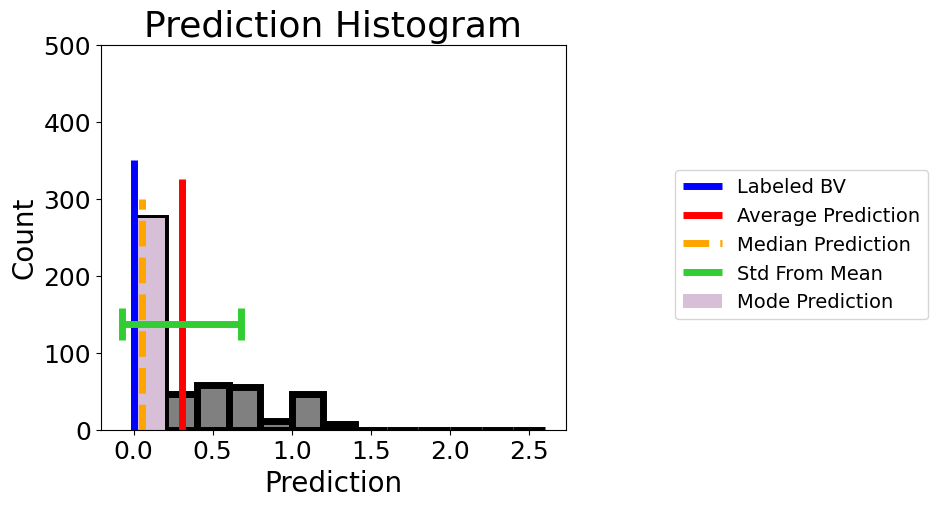

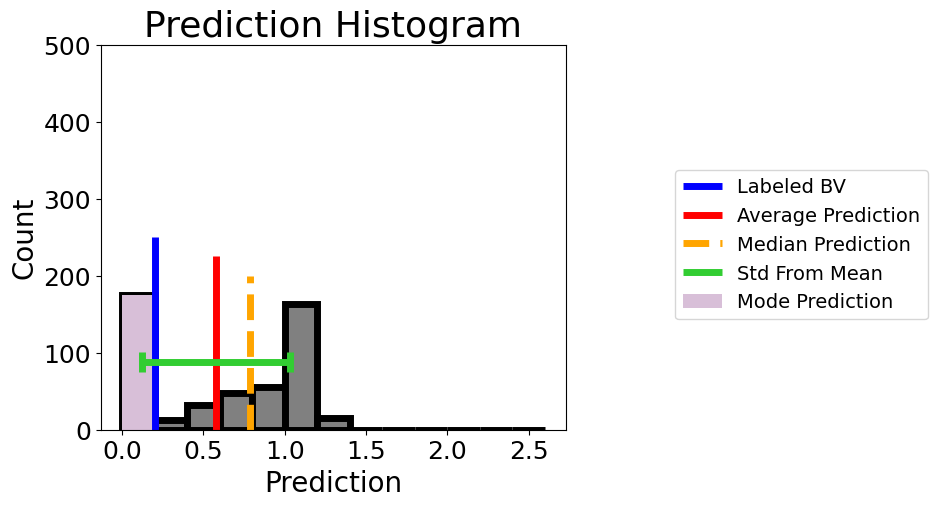

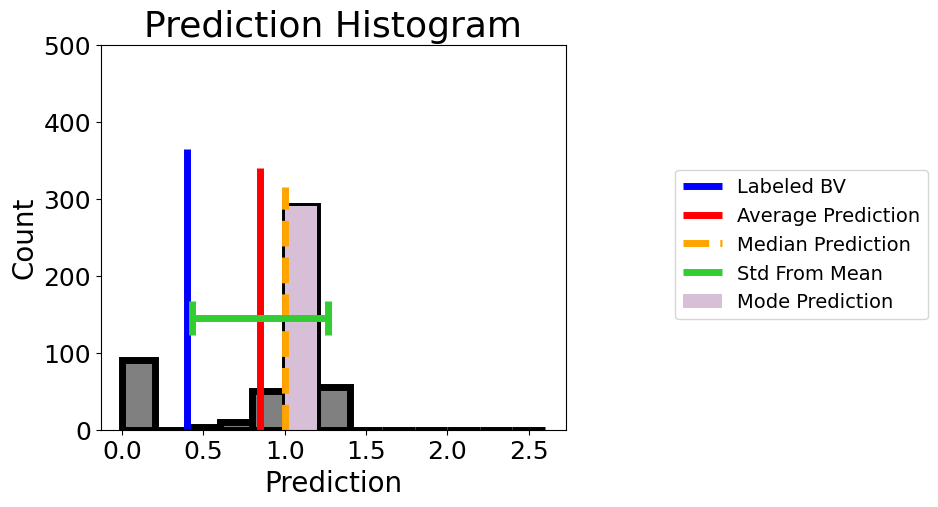

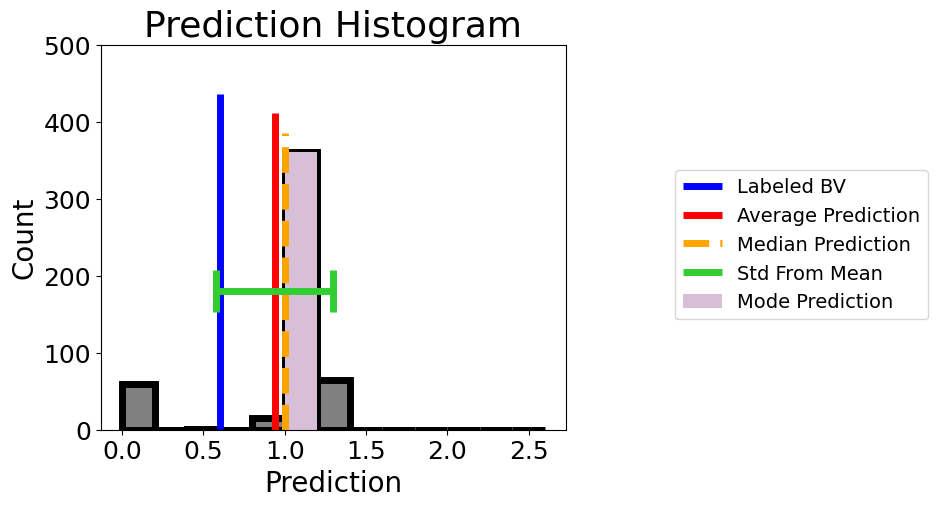

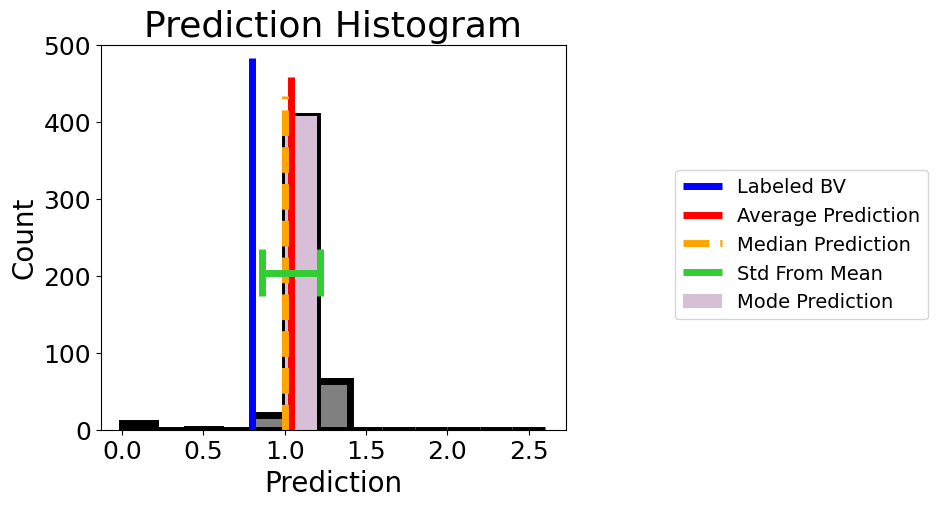

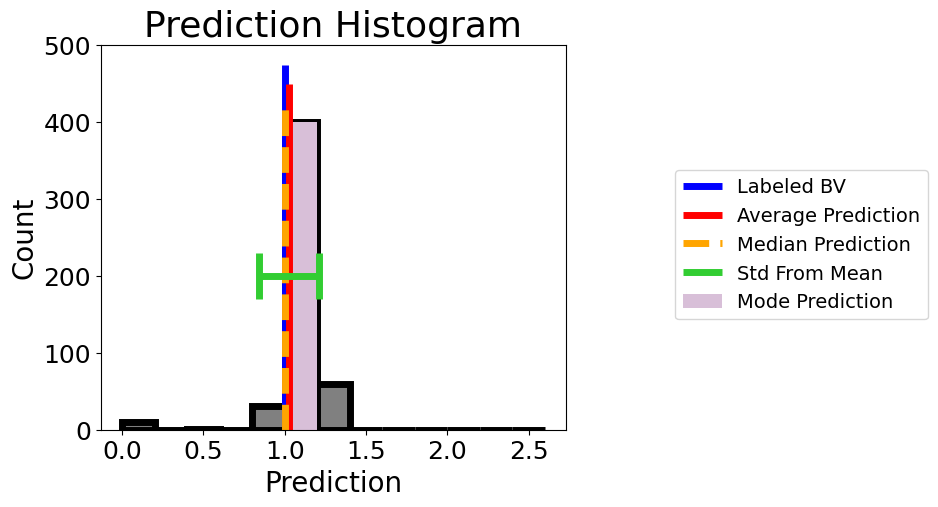

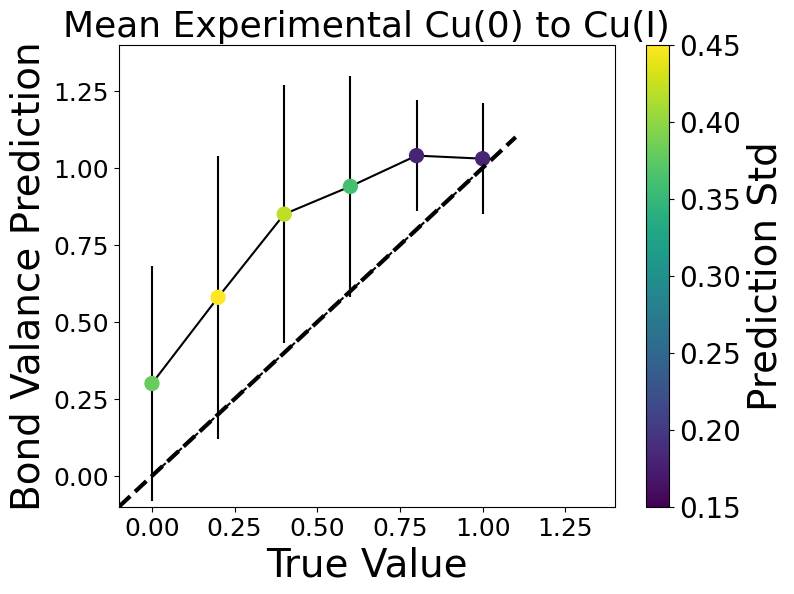

In [126]:
test_rf_obj.experimental_mixed_valent(catagory = '0-1', colorbar_range = [0.15, 0.45], savefigure = False, true_vals = [0.0, 1.00, 2.00],
                                     show_hists = True, first_comp = [], second_comp = [], print_predictions = False,
                                     prediction_type = 'Mean', folder_path = 'C:/Users/smgls/Materials_database/Cu_deconvolved_spectra',
                                     folder_path_type = 'TEAM I', num_mixed_vals = 6, show_err = True,)

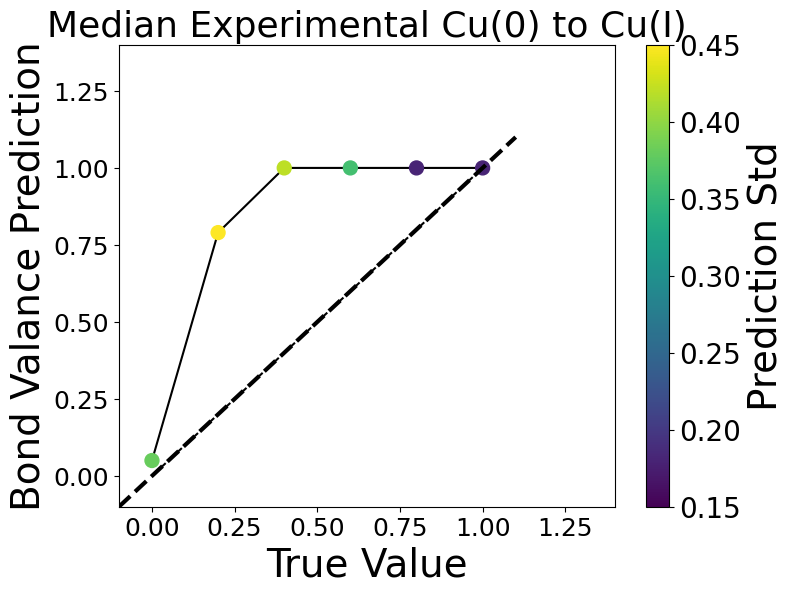

In [127]:
test_rf_obj.experimental_mixed_valent(catagory = '0-1', colorbar_range = [0.15, 0.45], savefigure = False, true_vals = [0.0, 1.00, 2.00],
                                     show_hists = False, first_comp = [], second_comp = [], print_predictions = False,
                                     prediction_type = 'Median', folder_path = 'C:/Users/smgls/Materials_database/Cu_deconvolved_spectra',
                                     folder_path_type = 'TEAM I', num_mixed_vals = 6, show_err = False,)

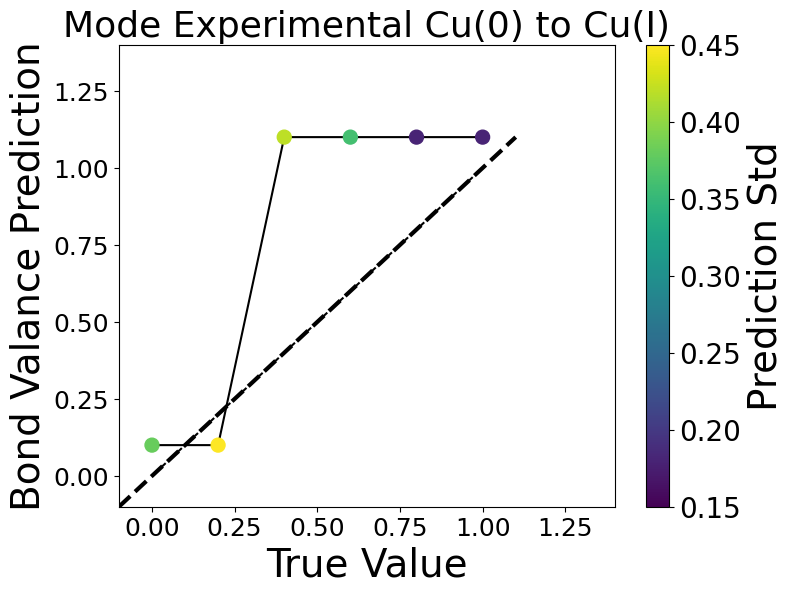

In [128]:
test_rf_obj.experimental_mixed_valent(catagory = '0-1', colorbar_range = [0.15, 0.45], savefigure = False, true_vals = [0.0, 1.00, 2.00],
                                     show_hists = False, first_comp = [], second_comp = [], print_predictions = False,
                                     prediction_type = 'Mode', folder_path = 'C:/Users/smgls/Materials_database/Cu_deconvolved_spectra',
                                     folder_path_type = 'TEAM I', num_mixed_vals = 6, show_err = False,)

<font size="6"> Empirical Correction Mixed Valent Prediction Figure S15

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:59<00:00,  8.40it/s]


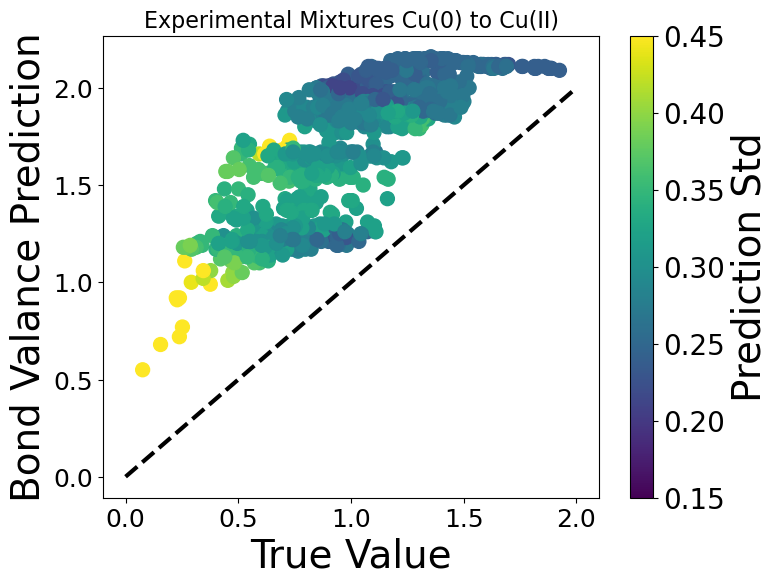

In [64]:
test_rf_obj.experimental_mixed_valent(catagory = '0-2', colorbar_range = [0.15, 0.45], savefigure = True, true_vals = [0.0, 1.00, 2.0],
                                     show_hists = False,  num_mixed_vals = 1000, folder_path = 'C:/Users/smgls/Materials_database/xas paper',
                                     folder_path_type = 'csv', spectrum_shift = 0.0, show_err = False)

In [58]:
from sklearn.linear_model import LinearRegression
inputs = []
for i in range(len(test_rf_obj.mixed_valent_summary[0])):
    inputs.append([test_rf_obj.mixed_valent_summary[0][i], test_rf_obj.mixed_valent_summary[1][i], test_rf_obj.mixed_valent_summary[2][i]])
    
    # inputs.append([test_rf_obj.mixed_valent_summary[0][i], test_rf_obj.mixed_valent_summary[2][i]])

    # inputs.append([test_rf_obj.mixed_valent_summary[0][i]])
# X = test_rf_obj.mixed_valent_summary[0]
y = test_rf_obj.mixed_valent_summary[3]
reg = LinearRegression().fit(inputs, y)
reg.score(inputs, y)

0.6436308477417172

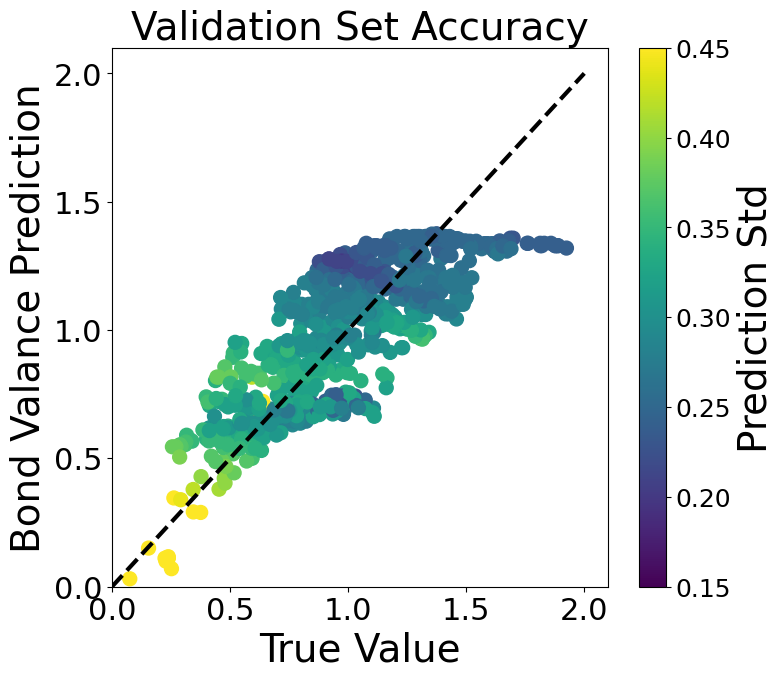

In [60]:
plt.figure(figsize=(8, 7))

sc = plt.scatter(y, reg.predict(inputs), s=100, c=test_rf_obj.mixed_valent_summary[2], vmin=0.15,
                     vmax=0.45, alpha = 1)
cb = plt.colorbar(sc, label='Prediction Std')
# print(len(count))
plt.plot(np.linspace(0,2,21), np.linspace(0,2,21), color='k', linestyle='--', linewidth=3)

ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=28)
text.set_font_properties(font)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(18)
    # t.set_weight('bold')

plt.xlim([0,2.1])
plt.ylim([0,2.1])

plt.yticks(fontsize = 18)
plt.xticks([0,0.5,1,1.5,2], fontsize = 22)
plt.yticks([0,0.5,1,1.5,2], fontsize = 22)

plt.xlabel('True Value', fontsize=28)
plt.ylabel('Bond Valance Prediction', fontsize=28)
plt.title('Validation Set Accuracy', fontsize = 28)

r2_score(y, reg.predict(inputs))

plt.rcParams['pdf.fonttype'] = 'truetype'
plt.savefig('Experimental Mixtures Validation Set.pdf', bbox_inches='tight', transparent=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [17:48<00:00,  1.07s/it]


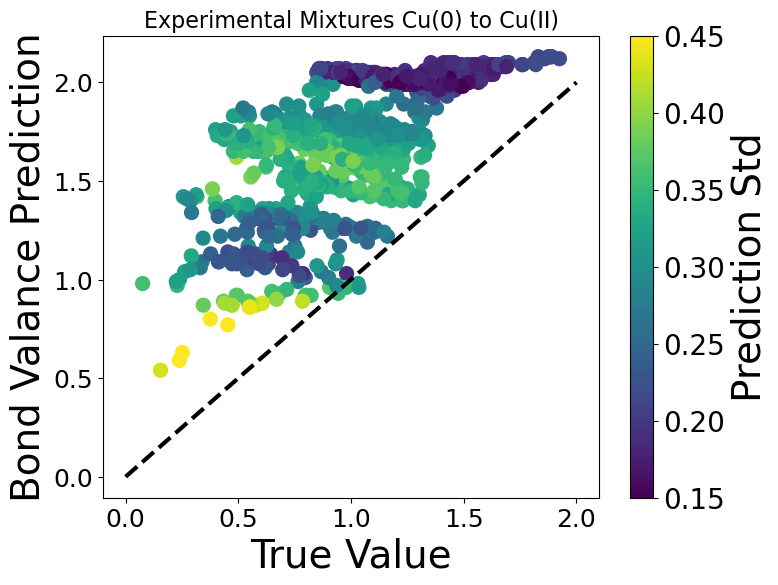

In [87]:
test_rf_obj.experimental_mixed_valent(catagory = '0-2', colorbar_range = [0.15, 0.45], savefigure = True, true_vals = [0.0, 1.00, 2.0],
                                     show_hists = False, num_mixed_vals = 1000, spectrum_shift = 0.0, show_err = False)

0.4744180570892824


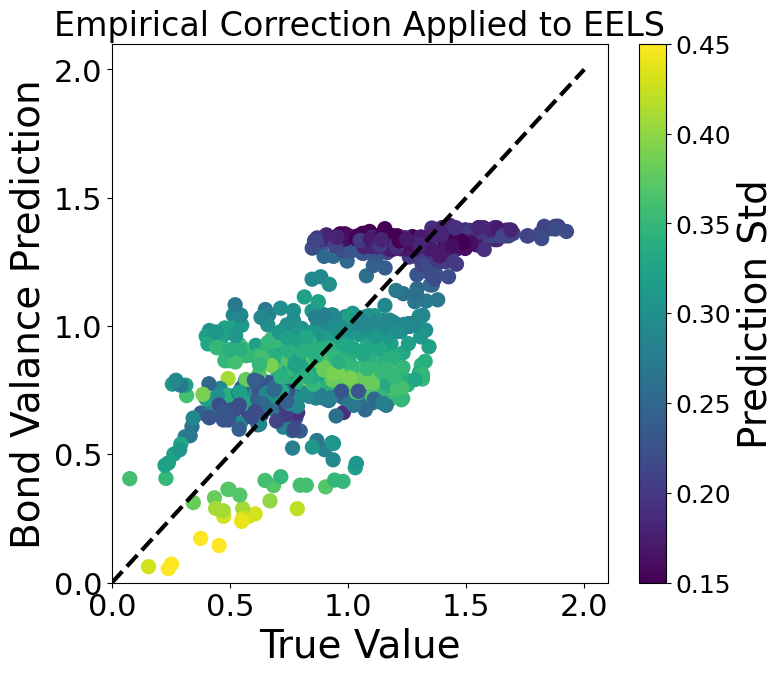

In [88]:
inputs = []
for i in range(len(test_rf_obj.mixed_valent_summary[0])):
    inputs.append([test_rf_obj.mixed_valent_summary[0][i], test_rf_obj.mixed_valent_summary[1][i], test_rf_obj.mixed_valent_summary[2][i]])

plt.figure(figsize=(8, 7))

sc = plt.scatter(y, reg.predict(inputs), s=100, c=test_rf_obj.mixed_valent_summary[2], vmin=0.15,
                     vmax=0.45, alpha = 1)
cb = plt.colorbar(sc, label='Prediction Std')
# print(len(count))
plt.plot(np.linspace(0,2,21), np.linspace(0,2,21), color='k', linestyle='--', linewidth=3)

ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=28)
text.set_font_properties(font)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(18)
    # t.set_weight('bold')

plt.xlim([0,2.1])
plt.ylim([0,2.1])

plt.yticks(fontsize = 18)
plt.xticks([0,0.5,1,1.5,2], fontsize = 22)
plt.yticks([0,0.5,1,1.5,2], fontsize = 22)

plt.title('Empirical Correction Applied to EELS', fontsize = 24)
plt.xlabel('True Value', fontsize=28)
plt.ylabel('Bond Valance Prediction', fontsize=28)

print(r2_score(y, reg.predict(inputs)))

plt.rcParams['pdf.fonttype'] = 'truetype'
plt.savefig('EELS Experimental Mixtures Test Set.pdf', bbox_inches='tight', transparent=True)

<font size="6"> Quantitative Noise Analysis Figure S16

In [131]:
output_zero = nio.dm.dmReader("Cu_deconvolved_spectra/Cu Metal Deconvolved Spectrum.dm4")
output_one = nio.dm.dmReader("Cu_deconvolved_spectra/Cu2O Deconvolved Spectrum.dm4")
output_two = nio.dm.dmReader("Cu_deconvolved_spectra/CuO Deconvolved Spectrum.dm4")

intens_zero = output_zero['data']
energies_zero = output_zero['coords'][0]

intens_one = output_one['data']
energies_one = output_one['coords'][0]

intens_two = output_two['data']
energies_two = output_two['coords'][0]

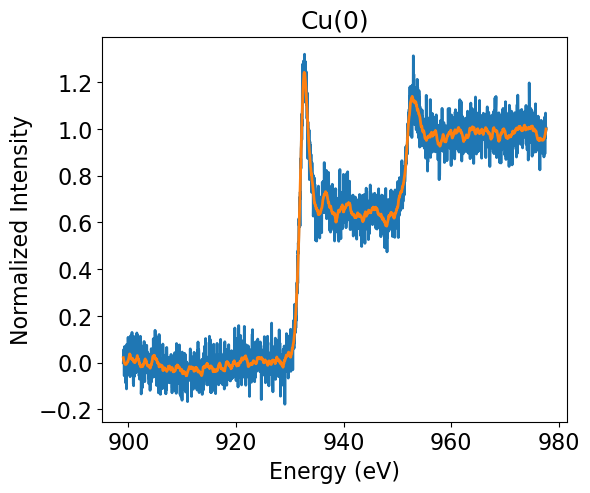

0.033399086


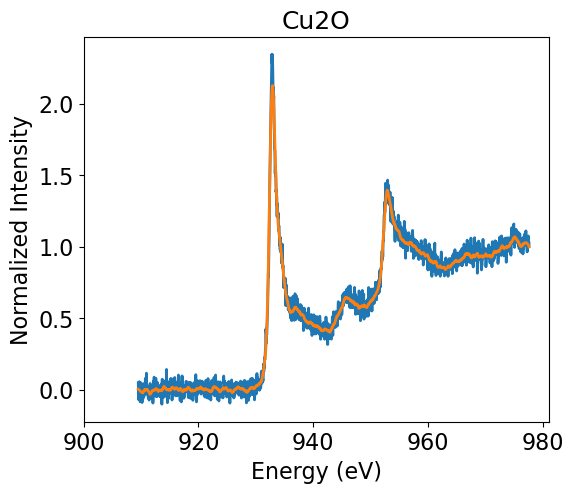

0.027662057


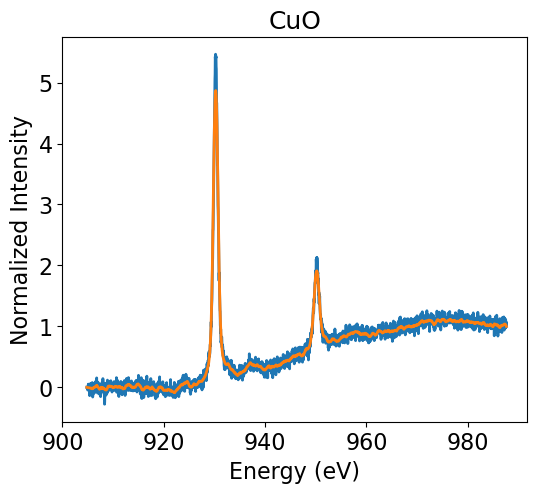

0.051577244


In [132]:
labels = ['Cu(0)', 'Cu2O', 'CuO']
count = 0
for val in [[intens_zero, energies_zero], [intens_one, energies_one], [intens_two, energies_two]]:
    intens = val[0]/val[0][-1]
    energies = val[1]

    spec = savgol_filter(intens, 51, 3)
    spec = spec/spec[-1]
    
    plt.figure(figsize = (6,5))
    plt.plot(energies, intens, linewidth = 2)
    plt.plot(energies, spec, linewidth = 2)
    plt.title(labels[count], fontsize = 18)
    plt.xticks([900, 920, 940, 960, 980], fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.ylabel('Normalized Intensity', fontsize = 16)
    plt.xlabel('Energy (eV)', fontsize = 16)

    
    plt.rcParams['pdf.fonttype'] = 'truetype'
    plt.savefig(labels[count]+'.pdf', bbox_inches='tight', transparent=True)    
    plt.show()

    errors = np.abs(spec - intens)
    print(np.std(errors))
    count += 1 

<font size="6"> FEFF Experiment Comparison For CuS Figure S17

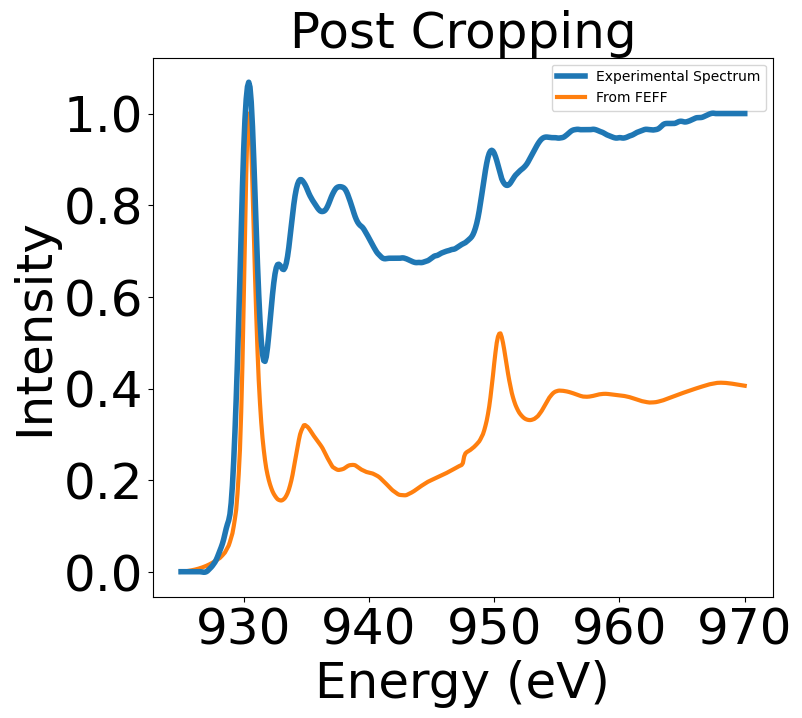

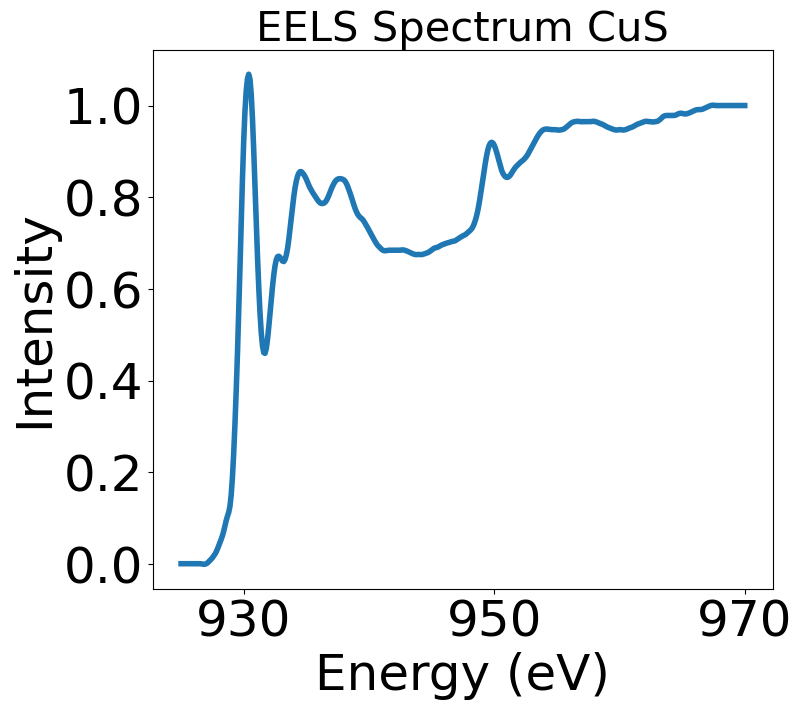

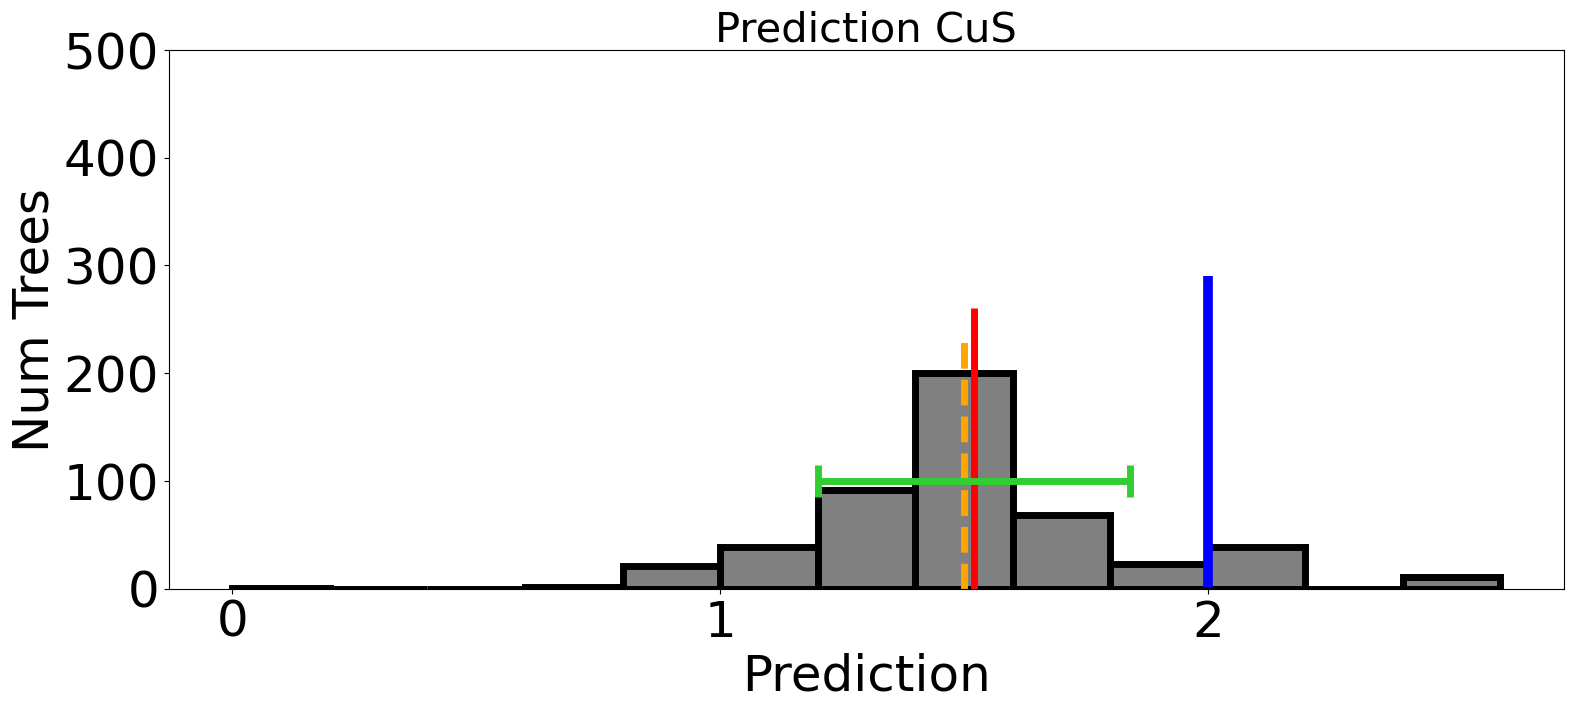

In [68]:
test_rf_obj.predict_experiment_folder('CuS/', spectra_type = 'csv', 
                                      shifts = [-2], theory_column = 'TEAM_1_aligned_925_970', smoothings = [[15,3]], 
                                      show_hist=True, show_inputted_spectrum=False, print_details = False, show_plots=False,
                                     savefigure=True, theory_indicies = [2488], check_alignment = True)